In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

In [2]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2025-07-07 10:43:04.425421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 10:43:04.436350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751865184.449028  107262 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751865184.452873  107262 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751865184.462315  107262 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Loader

In [4]:
import tensorflow as tf
import numpy as np
import os
import glob
import h5py
from pathlib import Path
import matplotlib.pyplot as plt

class PreprocessedCTSequence(tf.keras.utils.Sequence):
    """
    Keras Sequence generator for preprocessed CT images stored in HDF5 files.
    This generator is much more efficient as it loads already preprocessed data.
    """
    
    def __init__(self, 
                 preprocessed_data_path,
                 batch_size=4,
                 augmentation=False,
                 shuffle=True,
                 validation_split=0,
                 is_validation=False):
        """
        Initialize the preprocessed CT image Keras Sequence.
        
        Args:
            preprocessed_data_path: Path to the preprocessed data files
            batch_size: Batch size for training
            augmentation: Whether to use data augmentation
            shuffle: Whether to shuffle the data between epochs
            validation_split: Fraction of data to use for validation
            is_validation: Whether this is a validation sequence
        """
        self.data_path = preprocessed_data_path
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.validation_split = validation_split
        self.is_validation = is_validation
        
        # Find all available preprocessed patient files
        self.patient_files = sorted(glob.glob(os.path.join(self.data_path, "patient_*.h5")))
        print(f"Found {len(self.patient_files)} preprocessed patient files")
        
        # Split into training and validation sets
        if self.is_validation:
            # Use the last validation_split fraction for validation
            split_idx = int(len(self.patient_files) * (1 - validation_split))
            self.patient_files = self.patient_files[split_idx:]
            print(f"Using {len(self.patient_files)} patients for validation")
        else:
            # Use the first (1-validation_split) fraction for training
            split_idx = int(len(self.patient_files) * (1 - validation_split))
            self.patient_files = self.patient_files[:split_idx]
            print(f"Using {len(self.patient_files)} patients for training")
        
        # Shuffle initially if needed
        if self.shuffle:
            np.random.shuffle(self.patient_files)
    
    def __len__(self):
        return len(self.patient_files) // self.batch_size

    
    def __getitem__(self, idx):
        """Get batch at position idx as required by Keras Sequence."""
        # Get patient files for this batch
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.patient_files))
        batch_files = self.patient_files[start_idx:end_idx]
        
        # CRITICAL FIX: If no files in batch, raise IndexError to signal end
        if not batch_files:
            raise IndexError("Batch index out of range")
        
        # Prepare batch arrays
        batch_images = []
        batch_masks = []
        
        # Load data for each patient in the batch
        for file_path in batch_files:
            try:
                with h5py.File(file_path, 'r') as f:
                    ct = f['ct'][:]
                    mask = f['mask'][:]
                
                # Apply augmentation if enabled (not for validation)
                if self.augmentation and not self.is_validation:
                    ct, mask = self.apply_augmentation(ct, mask)
                
                batch_images.append(ct)
                batch_masks.append(mask)
                
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                # Skip corrupted files instead of returning empty batch
                continue
        
        
        if not batch_images:
            print(f"Warning: All files in batch {idx} failed to load, skipping...")
            # Return a valid single-sample batch instead of empty
            try:
                # Load a fallback sample from the first valid file
                for fallback_file in self.patient_files:
                    try:
                        with h5py.File(fallback_file, 'r') as f:
                            ct = f['ct'][:]
                            mask = f['mask'][:]
                        batch_images = [ct]
                        batch_masks = [mask]
                        break
                    except:
                        continue
            except:
                raise RuntimeError("No valid data files found")
        
        # Convert to numpy arrays
        batch_images = np.array(batch_images)
        batch_masks = np.array(batch_masks)
        
        return batch_images, batch_masks

        
    def on_epoch_end(self):
        """Called at the end of each epoch as required by Keras Sequence."""
        if self.shuffle:
            np.random.shuffle(self.patient_files)
    
    def apply_augmentation(self, image, mask):
        """Apply data augmentation to image and mask."""
        if not self.augmentation:
            return image, mask
        
        # Random flip
        if np.random.rand() > 0.5:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        
        # Random flip
        if np.random.rand() > 0.5:
            image = np.flip(image, axis=2)
            mask = np.flip(mask, axis=2)
        
        # Random rotation (only in xy plane)
        if np.random.rand() > 0.5:
            k = np.random.randint(1, 4)  # 1, 2, or 3 for 90, 180, 270 degrees
            image = np.rot90(image, k=k, axes=(1, 2))
            mask = np.rot90(mask, k=k, axes=(1, 2))
        
        # Random intensity variation for images (not masks)
        if np.random.rand() > 0.5:
            # Apply gamma correction
            gamma = np.random.uniform(0.8, 1.2)
            image = np.power(image, gamma)
            image = np.clip(image, 0, 1)
        
        return image, mask
    
    def get_patient_id_from_file(self, file_path):
        """Extract patient ID from filename."""
        filename = os.path.basename(file_path)
        return int(filename.replace("patient_", "").replace(".h5", ""))
    
    def visualize_sample(self, index=None, slice_idx=None):
        """
        Visualize a sample patient's CT and mask data.
        
        Args:
            index: Index in the dataset to visualize, random if None
            slice_idx: Slice index to visualize, middle slice if None
        """
        if index is None:
            index = np.random.randint(0, len(self.patient_files))
        
        file_path = self.patient_files[index]
        patient_id = self.get_patient_id_from_file(file_path)
        
        # Load data
        try:
            with h5py.File(file_path, 'r') as f:
                ct = f['ct'][:]
                mask = f['mask'][:]
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return
        
        # Select slice to visualize
        if slice_idx is None:
            slice_idx = ct.shape[0] // 2  # Middle slice
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot CT
        axes[0].imshow(ct[slice_idx, :, :, 0], cmap='gray')
        axes[0].set_title(f"CT - Patient {patient_id}")
        axes[0].axis('off')
        
        # Plot mask
        axes[1].imshow(mask[slice_idx, :, :, 0], cmap='hot')
        axes[1].set_title(f"Mask - Patient {patient_id}")
        axes[1].axis('off')
        
        # Plot overlay
        axes[2].imshow(ct[slice_idx, :, :, 0], cmap='gray')
        axes[2].imshow(mask[slice_idx, :, :, 0], cmap='hot', alpha=0.5)
        axes[2].set_title(f"Overlay - Patient {patient_id}")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Patient {patient_id} - CT shape: {ct.shape}, Mask shape: {mask.shape}")
        print(f"CT value range: [{np.min(ct):.2f}, {np.max(ct):.2f}]")
        print(f"Mask value range: [{np.min(mask):.2f}, {np.max(mask):.2f}]")

def main():

    data_path = "/home/cds/Documents/Adithya/CAC/ProcessedData"
    
    # Create data generators
    train_gen = PreprocessedCTSequence(
        data_path,
        batch_size=2,
        augmentation=False,
        shuffle=True,
        validation_split=0,
        is_validation=False
    )




Found 448 preprocessed patient files
Using 448 patients for training


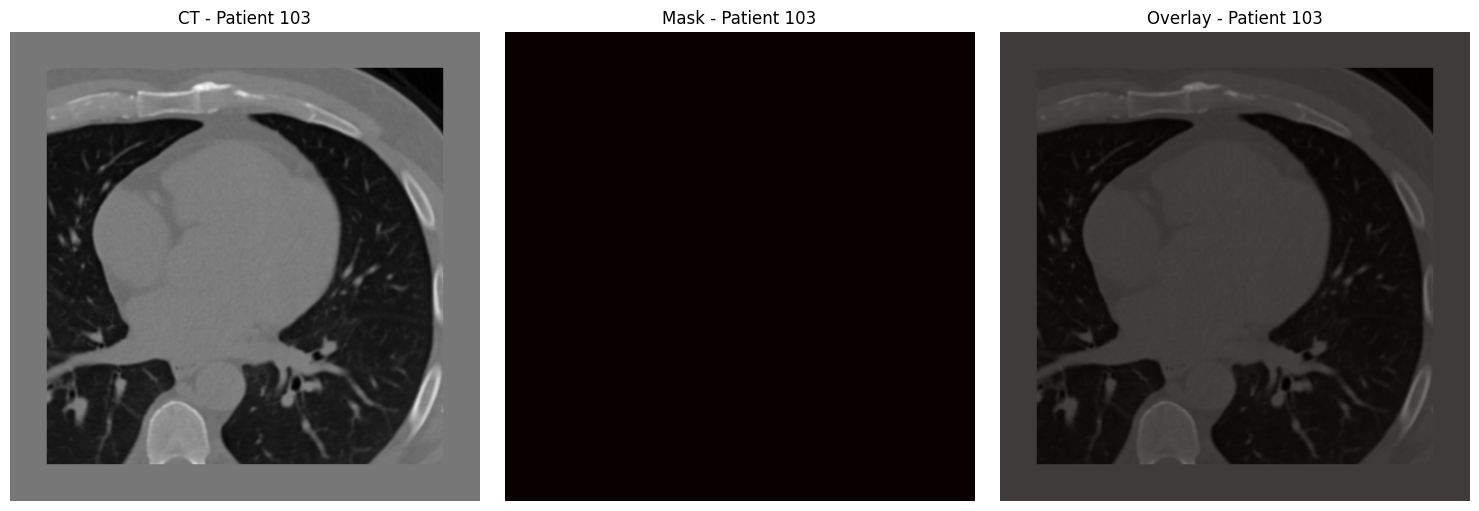

Patient 103 - CT shape: (64, 512, 512, 1), Mask shape: (64, 512, 512, 1)
CT value range: [-1024.00, 2842.00]
Mask value range: [0.00, 1.00]


In [5]:
if __name__ == "__main__":
    # Example of visualizing a random sample
    data_path = "/home/cds/Documents/Adithya/CAC/ProcessedData"
    data_gen = PreprocessedCTSequence(data_path, batch_size=1)
    data_gen.visualize_sample(index=65, slice_idx=24)

# Model

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer
import numpy as np

class TimestepEmbedding(Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim

    def call(self, timesteps):
        half_dim = self.dim // 2
        emb = tf.math.log(10000.0) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb
        
class SelfAttention3D(layers.Layer):
    def __init__(self, reduction_ratio=4, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.reduced_channels = self.channels // self.reduction_ratio
        

        self.query_conv = layers.Conv3D(self.reduced_channels, 1, name="query_conv")
        self.key_conv = layers.Conv3D(self.reduced_channels, 1, name="key_conv")
        self.value_conv = layers.Conv3D(self.channels, 1, name="value_conv")
        self.final_conv = layers.Conv3D(self.channels, 1, name="final_conv")
        
        super().build(input_shape)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        query = self.query_conv(inputs)
        key = self.key_conv(inputs)      
        value = self.value_conv(inputs)  
        
        query_flat = tf.reshape(query, [batch_size, -1, self.reduced_channels]) 
        key_flat = tf.reshape(key, [batch_size, -1, self.reduced_channels])     
        value_flat = tf.reshape(value, [batch_size, -1, self.channels])         
        
        scores = tf.matmul(query_flat, key_flat, transpose_b=True) 
        attention = tf.nn.softmax(scores / tf.sqrt(tf.cast(self.reduced_channels, tf.float32)))
        
        context = tf.matmul(attention, value_flat) 
        
        context = tf.reshape(context, tf.shape(value)) 
        
        return self.final_conv(context) + inputs
        
    def get_config(self):
        config = super().get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)

        
    def get_config(self):
        config = super().get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)



def Diffusion3DUNet_mask_prediction(input_shape, num_classes=1):
    ct_input = layers.Input(shape=input_shape, name='ct_input')
    noisy_mask_input = layers.Input(shape=input_shape, name='noisy_mask_input')  
    t_input = layers.Input(shape=(), dtype=tf.int32, name='timestep')

    with tf.device('/GPU:0'):
        t_emb = TimestepEmbedding(128)(t_input)
        t_emb = layers.Dense(128, activation='relu')(t_emb)
        
        ct_enc1 = layers.Conv3D(16, 3, padding='same', activation='relu')(ct_input)
        ct_pool1 = layers.MaxPooling3D()(ct_enc1)
        #ct_pool1 = SelfAttention3D()(ct_pool1)

        ct_enc2 = layers.Conv3D(32, 3, padding='same', activation='relu')(ct_pool1)
        ct_pool2 = layers.MaxPooling3D()(ct_enc2)
        #ct_pool2 = SelfAttention3D()(ct_pool2)
        
        ct_enc3 = layers.Conv3D(64, 3, padding='same', activation='relu')(ct_pool2)
        ct_pool3 = layers.MaxPooling3D()(ct_enc3)
        ct_pool3 = SelfAttention3D()(ct_pool3)
        
        mask_enc1 = layers.Conv3D(16, 3, padding='same', activation='relu')(noisy_mask_input)
        mask_pool1 = layers.MaxPooling3D()(mask_enc1)
        
        fused1 = layers.Add()([mask_pool1, ct_pool1])  
        
        t_emb_1 = layers.Reshape((1, 1, 1, 128))(t_emb)
        t_emb_1 = layers.Conv3D(16, 1, activation='relu')(t_emb_1)  
        fused1 = fused1 * (1 + t_emb_1)
        fused1 = layers.Conv3D(32, 3, padding='same', activation='relu')(fused1)
        fused1 = layers.Conv3D(16, 3, padding='same', activation='relu')(fused1)

        mask_enc2 = layers.Conv3D(32, 3, padding='same', activation='relu')(fused1)
        mask_pool2 = layers.MaxPooling3D()(mask_enc2)
        
        fused2 = layers.Add()([mask_pool2, ct_pool2])  
        
        t_emb_2 = layers.Conv3D(32, 1, activation='relu')(t_emb_1)  
        fused2 = fused2 * (1 + t_emb_2)
        fused2 = layers.Conv3D(64, 3, padding='same', activation='relu')(fused2)
        fused2 = layers.Conv3D(32, 3, padding='same', activation='relu')(fused2)
        
        mask_enc3 = layers.Conv3D(64, 3, padding='same', activation='relu')(fused2)
        mask_pool3 = layers.MaxPooling3D()(mask_enc3)
        
        fused3 = layers.Add()([mask_pool3, ct_pool3]) 
        
        t_emb_3 = layers.Conv3D(64, 1, activation='relu')(t_emb_2)  
        fused3 = fused3 * (1 + t_emb_3)
        
        bottleneck = layers.Conv3D(128, 3, padding='same', activation='relu')(fused3)
        bottleneck = SelfAttention3D()(bottleneck)
        x = layers.Conv3DTranspose(64, 3, strides=2, padding='same', activation='relu')(bottleneck)
       # x = SelfAttention3D()(x)
        x = layers.Add()([x, mask_enc3]) 
        
        x = layers.Conv3DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
        x = layers.Conv3D(32, 3, padding='same', activation='relu')(x)
       # x = SelfAttention3D()(x)
        x = layers.Add()([x, mask_enc2])
        x = layers.Conv3D(32, 3, padding='same', activation='relu')(x)
        x = layers.Conv3DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
        x = layers.Conv3D(16, 3, padding='same', activation='relu')(x)
        x = layers.Add()([x, mask_enc1])  
        x = layers.Conv3D(16, 3, padding='same', activation='relu')(x)
        output = layers.Conv3D(num_classes, 1, activation='sigmoid')(x)

    model = models.Model([ct_input, noisy_mask_input, t_input], output)
    return model

input_shape = (64, 512, 512, 1)
model = Diffusion3DUNet_mask_prediction(input_shape)
model.summary()





import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer
import numpy as np

class MCDropout(layers.Dropout):
    """Monte Carlo Dropout layer that remains active during inference"""
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

class TimestepEmbedding(Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim

    def call(self, timesteps):
        half_dim = self.dim // 2
        emb = tf.math.log(10000.0) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb
        
class SelfAttention3D(layers.Layer):
    def __init__(self, reduction_ratio=4, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.reduced_channels = self.channels // self.reduction_ratio
        
        self.query_conv = layers.Conv3D(self.reduced_channels, 1, name="query_conv")
        self.key_conv = layers.Conv3D(self.reduced_channels, 1, name="key_conv")
        self.value_conv = layers.Conv3D(self.channels, 1, name="value_conv")
        self.final_conv = layers.Conv3D(self.channels, 1, name="final_conv")
        
        super().build(input_shape)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        query = self.query_conv(inputs)
        key = self.key_conv(inputs)      
        value = self.value_conv(inputs)  
        
        query_flat = tf.reshape(query, [batch_size, -1, self.reduced_channels]) 
        key_flat = tf.reshape(key, [batch_size, -1, self.reduced_channels])     
        value_flat = tf.reshape(value, [batch_size, -1, self.channels])         
        
        scores = tf.matmul(query_flat, key_flat, transpose_b=True) 
        attention = tf.nn.softmax(scores / tf.sqrt(tf.cast(self.reduced_channels, tf.float32)))
        
        context = tf.matmul(attention, value_flat) 
        context = tf.reshape(context, tf.shape(value)) 
        
        return self.final_conv(context) + inputs
        
    def get_config(self):
        config = super().get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)

def Diffusion3DUNet_mask_prediction(input_shape, num_classes=1, dropout_rate=0.2):

    ct_input = layers.Input(shape=input_shape, name='ct_input')
    noisy_mask_input = layers.Input(shape=input_shape, name='noisy_mask_input')  
    t_input = layers.Input(shape=(), dtype=tf.int32, name='timestep')

    with tf.device('/GPU:0'):
        # Timestep embedding
        t_emb = TimestepEmbedding(128)(t_input)
        t_emb = layers.Dense(128, activation='relu')(t_emb)

        # CT Encoder Path
        ct_enc1 = layers.Conv3D(16, 3, padding='same', activation='leaky_relu')(ct_input)
        ct_enc1 = MCDropout(dropout_rate)(ct_enc1)  # MC Dropout after conv
        ct_pool1 = layers.MaxPooling3D()(ct_enc1)

        ct_enc2 = layers.Conv3D(32, 3, padding='same', activation='leaky_relu')(ct_pool1)
        ct_enc2 = MCDropout(dropout_rate)(ct_enc2)  # MC Dropout after conv
        ct_pool2 = layers.MaxPooling3D()(ct_enc2)
        
        ct_enc3 = layers.Conv3D(64, 3, padding='same', activation='leaky_relu')(ct_pool2)
        ct_enc3 = MCDropout(dropout_rate)(ct_enc3)  # MC Dropout after conv
        ct_pool3 = layers.MaxPooling3D()(ct_enc3)

        # Mask Encoder Path with Fusion
        mask_enc1 = layers.Conv3D(16, 3, padding='same', activation='leaky_relu')(noisy_mask_input)
        mask_enc1 = MCDropout(dropout_rate)(mask_enc1)
        mask_pool1 = layers.MaxPooling3D()(mask_enc1)
        
        # First fusion with timestep embedding
        fused1 = layers.Add()([mask_pool1, ct_pool1])  
        t_emb_1 = layers.Reshape((1, 1, 1, 128))(t_emb)
        t_emb_1 = layers.Conv3D(16, 1, activation='leaky_relu')(t_emb_1)  
        fused1 = fused1 * (1 + t_emb_1)
        fused1 = layers.Conv3D(32, 3, padding='same', activation='leaky_relu')(fused1)
        fused1 = MCDropout(dropout_rate)(fused1)
        fused1 = layers.Conv3D(16, 3, padding='same', activation='leaky_relu')(fused1)
        fused1 = MCDropout(dropout_rate)(fused1)

        mask_enc2 = layers.Conv3D(32, 3, padding='same', activation='leaky_relu')(fused1)
        mask_enc2 = MCDropout(dropout_rate)(mask_enc2)
        mask_pool2 = layers.MaxPooling3D()(mask_enc2)
        
        # Second fusion with timestep embedding
        fused2 = layers.Add()([mask_pool2, ct_pool2])  
        t_emb_2 = layers.Conv3D(32, 1, activation='leaky_relu')(t_emb_1)  
        fused2 = fused2 * (1 + t_emb_2)
       ## fused2 = layers.Conv3D(64, 3, padding='same', activation='leaky_relu')(fused2)
        fused2 = MCDropout(dropout_rate)(fused2)
        fused2 = layers.Conv3D(32, 3, padding='same', activation='leaky_relu')(fused2)
        fused2 = MCDropout(dropout_rate)(fused2)
        
        mask_enc3 = layers.Conv3D(64, 3, padding='same', activation='leaky_relu')(fused2)
        mask_enc3 = MCDropout(dropout_rate)(mask_enc3)
        mask_pool3 = layers.MaxPooling3D()(mask_enc3)
        
        # Third fusion with timestep embedding
        fused3 = layers.Add()([mask_pool3, ct_pool3]) 
        t_emb_3 = layers.Conv3D(64, 1, activation='leaky_relu')(t_emb_2)  
        fused3 = fused3 * (1 + t_emb_3)
        fused3 = MCDropout(dropout_rate)(fused3)
        
        # Bottleneck
        bottleneck = layers.Conv3D(128, 3, padding='same', activation='leaky_relu')(fused3)
        bottleneck = MCDropout(dropout_rate)(bottleneck)
        bottleneck = SelfAttention3D()(bottleneck)
        bottleneck = MCDropout(dropout_rate)(bottleneck)
        
        # Decoder Path with Skip Connections
        x = layers.Conv3DTranspose(64, 3, strides=2, padding='same', activation='leaky_relu')(bottleneck)
        x = MCDropout(dropout_rate)(x)
        x = layers.Add()([x, mask_enc3]) 
        x = layers.Conv3D(64, 3, padding='same', activation='leaky_relu')(x)
        x = MCDropout(dropout_rate)(x)
        
        x = layers.Conv3DTranspose(32, 3, strides=2, padding='same', activation='leaky_relu')(x)
        x = MCDropout(dropout_rate)(x)
        x = layers.Add()([x, mask_enc2])
        x = layers.Conv3D(32, 3, padding='same', activation='leaky_relu')(x)
        x = MCDropout(dropout_rate)(x)
        
        x = layers.Conv3DTranspose(16, 3, strides=2, padding='same', activation='leaky_relu')(x)
        x = MCDropout(dropout_rate)(x)
        x = layers.Add()([x, mask_enc1])  
        x = layers.Conv3D(16, 3, padding='same', activation='leaky_relu')(x)
        x = MCDropout(dropout_rate)(x)
        
        # Final output layer (no dropout here)
        output = layers.Conv3D(num_classes, 1, activation='sigmoid')(x)

    model = models.Model([ct_input, noisy_mask_input, t_input], output)
    return model


input_shape = (64, 512, 512, 1)
model = Diffusion3DUNet_mask_prediction(input_shape)
model.summary()

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer
import numpy as np


class MCDropout(layers.Dropout):
    """Monte Carlo Dropout layer that remains active during inference"""
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)


class TimestepEmbedding(Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim

    def call(self, timesteps):
        half_dim = self.dim // 2
        emb = tf.math.log(10000.0) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb
        

class SelfAttention3D(layers.Layer):
    def __init__(self, reduction_ratio=4, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.reduced_channels = self.channels // self.reduction_ratio
        
        self.query_conv = layers.Conv3D(self.reduced_channels, 1, name="query_conv")
        self.key_conv = layers.Conv3D(self.reduced_channels, 1, name="key_conv")
        self.value_conv = layers.Conv3D(self.channels, 1, name="value_conv")
        self.final_conv = layers.Conv3D(self.channels, 1, name="final_conv")
        
        super().build(input_shape)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        query = self.query_conv(inputs)
        key = self.key_conv(inputs)      
        value = self.value_conv(inputs)  
        
        query_flat = tf.reshape(query, [batch_size, -1, self.reduced_channels]) 
        key_flat = tf.reshape(key, [batch_size, -1, self.reduced_channels])     
        value_flat = tf.reshape(value, [batch_size, -1, self.channels])         
        
        scores = tf.matmul(query_flat, key_flat, transpose_b=True) 
        attention = tf.nn.softmax(scores / tf.sqrt(tf.cast(self.reduced_channels, tf.float32)))
        
        context = tf.matmul(attention, value_flat) 
        context = tf.reshape(context, tf.shape(value)) 
        
        return self.final_conv(context) + inputs
        
    def get_config(self):
        config = super().get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)


def residual_block(inputs, filters, kernel_size=3, strides=1):
    """Residual block with batch normalization and leaky ReLU activation"""
    x = layers.Conv3D(filters-4, kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    
    x = layers.Conv3D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    if strides > 1 or inputs.shape[-1] != filters:
        skip = layers.Conv3D(filters, 1, strides=strides, padding='same')(inputs)
        skip = layers.BatchNormalization()(skip)
    else:
        skip = inputs
    
    x = layers.Add()([x, skip])
    x = layers.LeakyReLU(alpha=0.01)(x)
    return x


def Diffusion3DUNet_mask_prediction(input_shape, num_classes=1, dropout_rate=0.2):
    
    ct_input = layers.Input(shape=input_shape, name='ct_input')
    noisy_mask_input = layers.Input(shape=input_shape, name='noisy_mask_input')  
    t_input = layers.Input(shape=(), dtype=tf.int32, name='timestep')

    with tf.device('/GPU:0'):
        # Timestep embedding
        t_emb = TimestepEmbedding(64)(t_input)
        t_emb = layers.Dense(64, activation='relu')(t_emb)

        # CT Encoder Path with Residual Blocks
        ct_enc1 = residual_block(ct_input, 8)
        ct_enc1 = MCDropout(dropout_rate)(ct_enc1)
        ct_pool1 = layers.MaxPooling3D()(ct_enc1)

        ct_enc2 = residual_block(ct_pool1, 16)
        ct_enc2 = MCDropout(dropout_rate)(ct_enc2)
        ct_pool2 = layers.MaxPooling3D()(ct_enc2)
        
        ct_enc3 = residual_block(ct_pool2, 32)
        ct_enc3 = MCDropout(dropout_rate)(ct_enc3)
        ct_pool3 = layers.MaxPooling3D()(ct_enc3)

        # Mask Encoder Path with Fusion and Residual Blocks
        mask_enc1 = residual_block(noisy_mask_input, 8)
        mask_enc1 = MCDropout(dropout_rate)(mask_enc1)
        mask_pool1 = layers.MaxPooling3D()(mask_enc1)
        
        # First fusion with timestep embedding
        fused1 = layers.Add()([mask_pool1, ct_pool1])  
        t_emb_1 = layers.Reshape((1, 1, 1, 64))(t_emb)
        t_emb_1 = layers.Conv3D(8, 1, activation='leaky_relu')(t_emb_1)  
        fused1 = fused1 * (1 + t_emb_1)
        fused1 = residual_block(fused1, 16)
        fused1 = MCDropout(dropout_rate)(fused1)
        fused1 = residual_block(fused1, 32)
        fused1 = MCDropout(dropout_rate)(fused1)

        mask_enc2 = residual_block(fused1, 16)
        mask_enc2 = MCDropout(dropout_rate)(mask_enc2)
        mask_pool2 = layers.MaxPooling3D()(mask_enc2)
        
        # Second fusion with timestep embedding
        fused2 = layers.Add()([mask_pool2, ct_pool2])  
        t_emb_2 = layers.Conv3D(16, 1, activation='leaky_relu')(t_emb_1)  
        fused2 = fused2 * (1 + t_emb_2)
        fused2 = MCDropout(dropout_rate)(fused2)
        fused2 = residual_block(fused2, 16)
        fused2 = MCDropout(dropout_rate)(fused2)
        
        mask_enc3 = residual_block(fused2, 32)
        mask_enc3 = MCDropout(dropout_rate)(mask_enc3)
        mask_pool3 = layers.MaxPooling3D()(mask_enc3)
        
        # Third fusion with timestep embedding
        fused3 = layers.Add()([mask_pool3, ct_pool3]) 
        t_emb_3 = layers.Conv3D(32, 1, activation='leaky_relu')(t_emb_2)  
        fused3 = fused3 * (1 + t_emb_3)
        fused3 = MCDropout(dropout_rate)(fused3)
        
        # Bottleneck with Residual Block
        bottleneck = residual_block(fused3, 64)
        bottleneck = MCDropout(dropout_rate)(bottleneck)
        bottleneck = SelfAttention3D()(bottleneck)
        bottleneck = MCDropout(dropout_rate)(bottleneck)
        
        # Decoder Path with Skip Connections and Residual Blocks
        x = layers.Conv3DTranspose(32, 3, strides=2, padding='same', activation='leaky_relu')(bottleneck)
        x = MCDropout(dropout_rate)(x)
        x = layers.Add()([x, mask_enc3]) 
        x = residual_block(x, 32)
        x = MCDropout(dropout_rate)(x)
        
        x = layers.Conv3DTranspose(16, 3, strides=2, padding='same', activation='leaky_relu')(x)
        x = MCDropout(dropout_rate)(x)
        x = layers.Add()([x, mask_enc2])
        x = residual_block(x, 16)
        x = MCDropout(dropout_rate)(x)
        
        x = layers.Conv3DTranspose(8, 3, strides=2, padding='same', activation='leaky_relu')(x)
        x = MCDropout(dropout_rate)(x)
        x = layers.Add()([x, mask_enc1])  
        x = residual_block(x, 8)
        x = MCDropout(dropout_rate)(x)
        
        # Final output layer (standard conv, no residual connection needed)
        output = layers.Conv3D(num_classes, 1, activation='sigmoid')(x)

    model = models.Model([ct_input, noisy_mask_input, t_input], output)
    return model


# Create and display model
input_shape = (64, 512, 512, 1)
model = Diffusion3DUNet_mask_prediction(input_shape)
model.summary()


I0000 00:00:1751865188.484861  107262 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1751865188.485060  107262 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46419 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6
/home/cds/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noisy_mask_input    │ (None, 64, 512,   │          0 │ -                 │
│ (InputLayer)        │ 512, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_input            │ (None, 64, 512,   │          0 │ -                 │
│ (InputLayer)        │ 512, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 64, 512,   │        112 │ noisy_mask_input… │
│                     │ 512, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 512,   │        112 │ ct_input[0][0]    │
│                     │ 512, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 512,   │         16 │ conv3d_9[0][0]    │
│ (BatchNormalizatio… │ 512, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 512,   │         16 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 512, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 64, 512,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 512,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_10 (Conv3D)  │ (None, 64, 512,   │        872 │ leaky_re_lu_6[0]… │
│                     │ 512, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_11 (Conv3D)  │ (None, 64, 512,   │         16 │ noisy_mask_input… │
│                     │ 512, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 64, 512,   │        872 │ leaky_re_lu[0][0] │
│                     │ 512, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 512,   │         16 │ ct_input[0][0]    │
│                     │ 512, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 512,   │         32 │ conv3d_10[0][0]   │
│ (BatchNormalizatio… │ 512, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 512,   │         32 │ conv3d_11[0][0]   │
│ (BatchNormalizatio… │ 512, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 512,   │         32 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 512, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 512,   │         32 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 512, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ timestep            │ (None)            │          0 │ -               

 Total params: 464,877 (1.77 MB)

 Trainable params: 463,349 (1.77 MB)

 Non-trainable params: 1,528 (5.97 KB)

# Training

In [7]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean


input_shape = (64, 512, 512, 1)
num_classes = 1
epochs = 50
batch_size = 1  

beta_schedule = np.linspace(1e-4, 0.02, 1000)

In [8]:
train_gen = PreprocessedCTSequence(
    preprocessed_data_path="/home/cds/Documents/Adithya/CAC/ProcessedData",
    batch_size=1,
    augmentation=False,
    shuffle=False,
    validation_split=0.3,
    is_validation=False
)

val_gen = PreprocessedCTSequence(
    preprocessed_data_path="/home/cds/Documents/Adithya/CAC/ProcessedData",
    batch_size=1,
    augmentation=False,
    shuffle=False,
    validation_split=0.3,
    is_validation=True
)

Found 448 preprocessed patient files
Using 313 patients for training
Found 448 preprocessed patient files
Using 135 patients for validation


In [9]:
def combined_dice_focal_loss(y_true,y_pred,gamma=2.0, alpha=0.25, smooth=1e-6):
    import tensorflow as tf
    from tensorflow.keras import backend as K

    def dice_loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        ce = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * ce)

   
    return focal_loss(y_true,y_pred)*10000



In [10]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def combined_dice_bce_mse_loss(dice_weight=1, bce_weight=1, mse_weight=1):

    def loss_function(y_true, y_pred): 

        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        dice_loss_val = dice_loss(y_true, y_pred)
        bce_loss_val = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
        mse_loss_val = tf.reduce_mean(tf.square(y_true - y_pred))
        
        total_loss = (dice_weight * dice_loss_val + 
                     bce_weight * bce_loss_val + 
                     mse_weight * mse_loss_val)
        
        return total_loss
    
    return loss_function


def combined_dice_bce_mse_loss_with_logging(dice_weight=10, bce_weight=1000, mse_weight=1000):
    def loss_function(y_true, y_pred):
        dice_loss_val = dice_loss(y_true, y_pred)
        bce_loss_val = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
        mse_loss_val = tf.reduce_mean(tf.square(y_true - y_pred))
        
        tf.summary.scalar('dice_loss', dice_loss_val)
        tf.summary.scalar('bce_loss', bce_loss_val)
        tf.summary.scalar('mse_loss', mse_loss_val)
        
        total_loss = (dice_weight * dice_loss_val + 
                     bce_weight * bce_loss_val + 
                     mse_weight * mse_loss_val)
        
        return total_loss
    
    return loss_function


In [11]:
model = tf.keras.models.load_model(
    "/home/cds/Documents/Adithya/cac_segmentation_diffatt_v9.keras",
    custom_objects={'TimestepEmbedding': TimestepEmbedding, 'SelfAttention3D':SelfAttention3D,'MCDropout':MCDropout},
    compile=False
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)
beta_schedule = tf.cast(beta_schedule, tf.float32)
alpha_schedule = 1.0 - beta_schedule
alpha_bar = tf.math.cumprod(alpha_schedule)
loss_fn=combined_dice_bce_mse_loss_with_logging()
for epoch in range(30):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_loss = Mean()
    
    for ct_batch, mask_batch in tqdm(train_gen, desc="Training"):
        ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
        if ct_batch.shape[0] == 0:
            continue
        mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)

        B = ct_batch.shape[0]
        
        t = np.random.randint(1, 1000, size=(B,))
        t_tensor = tf.convert_to_tensor(t, dtype=tf.int32)
        

        noise = tf.random.normal(mask_batch.shape, dtype=tf.float32)
        
        alpha_bar_t = tf.gather(alpha_bar, t)
        alpha_bar_t_prev = tf.gather(alpha_bar, t-1)  
        
        alpha_bar_t = tf.reshape(alpha_bar_t, (-1, 1, 1, 1, 1))
        alpha_bar_t_prev = tf.reshape(alpha_bar_t_prev, (-1, 1, 1, 1, 1))
        
        sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = tf.sqrt(1.0 - alpha_bar_t)
        noisy_mask_t = sqrt_alpha_bar_t * mask_batch + sqrt_one_minus_alpha_bar_t * noise
        
        # sqrt_alpha_bar_t_prev = tf.sqrt(alpha_bar_t_prev)
        # sqrt_one_minus_alpha_bar_t_prev = tf.sqrt(1.0 - alpha_bar_t_prev)
        # target_mask_t_prev = sqrt_alpha_bar_t_prev * mask_batch + sqrt_one_minus_alpha_bar_t_prev * noise
       
        with tf.GradientTape() as tape:
            predicted_mask = model([ct_batch, noisy_mask_t, t_tensor])
            loss = loss_fn(mask_batch, predicted_mask)
        # print(loss)
        # plt.imshow(predicted_mask[0,25,:,:,0])
        # plt.pause(1) 
        grads = tape.gradient(loss, model.trainable_variables)
        grads = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in grads]
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss.update_state(loss)

    print(f"Epoch Loss: {epoch_loss.result().numpy()}")


In [12]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import Mean

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_pred_f = tf.cast(y_pred_f > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-6)
beta_schedule = tf.cast(beta_schedule, tf.float32)
alpha_schedule = 1.0 - beta_schedule
alpha_bar = tf.math.cumprod(alpha_schedule)
loss_fn = combined_dice_bce_mse_loss_with_logging()

for epoch in range(50):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_loss = Mean()
    epoch_dice = Mean()
    # Training Loop
    for ct_batch, mask_batch in tqdm(train_gen, desc="Training"):
        ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
        if ct_batch.shape[0] == 0:
            continue
        mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)

        B = ct_batch.shape[0]
        t = tf.fill((B,),1000)
        t_tensor = tf.cast(t, tf.int32)

        noise = tf.random.normal(mask_batch.shape, dtype=tf.float32)
        
        alpha_bar_t = tf.gather(alpha_bar, t)
        alpha_bar_t = tf.reshape(alpha_bar_t, (-1, 1, 1, 1, 1))
        sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = tf.sqrt(1.0 - alpha_bar_t)
        noisy_mask_t = sqrt_alpha_bar_t * mask_batch + sqrt_one_minus_alpha_bar_t * noise

        with tf.GradientTape() as tape:
            predicted_mask = model([ct_batch, noisy_mask_t, t_tensor])
            loss = loss_fn(mask_batch, predicted_mask)
        dice = dice_coef(mask_batch, predicted_mask)
        grads = tape.gradient(loss, model.trainable_variables)
        grads = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in grads]
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss.update_state(loss)
        epoch_dice.update_state(dice)

    print(f"Training Loss: {epoch_loss.result().numpy():.4f}")
    print(f"Training Dice Coefficient: {epoch_dice.result().numpy():.4f}")
    # Validation Loop
    val_dice = Mean()
    for val_ct_batch, val_mask_batch in tqdm(val_gen, desc="Validation"):
        val_ct_batch = tf.convert_to_tensor(val_ct_batch, dtype=tf.float32)
        if val_ct_batch.shape[0] == 0:
            continue
        val_mask_batch = tf.convert_to_tensor(val_mask_batch, dtype=tf.float32)
        
        B = val_ct_batch.shape[0]
        t_val = tf.fill((B,), 1000)
        #t_tensor = tf.cast(t_tensor, tf.int32)
        t_val_tensor = tf.convert_to_tensor(t_val, dtype=tf.int32)

        noise_val = tf.random.normal(val_mask_batch.shape, dtype=tf.float32)
        
        alpha_bar_t_val = tf.gather(alpha_bar, t_val)
        alpha_bar_t_val = tf.reshape(alpha_bar_t_val, (-1, 1, 1, 1, 1))
        sqrt_alpha_bar_t_val = tf.sqrt(alpha_bar_t_val)
        sqrt_one_minus_alpha_bar_t_val = tf.sqrt(1.0 - alpha_bar_t_val)
        noisy_val_mask = sqrt_alpha_bar_t_val * val_mask_batch + sqrt_one_minus_alpha_bar_t_val * noise_val

        predicted_val_mask = model([val_ct_batch, noisy_val_mask, t_val_tensor], training=False)
        dice_score = dice_coef(val_mask_batch, predicted_val_mask)
        val_dice.update_state(dice_score)

    print(f"Validation Dice Coefficient: {val_dice.result().numpy():.4f}")



Epoch 1/50


Training:   0%|          | 0/313 [00:00<?, ?it/s]

I0000 00:00:1751865223.630698  107262 cuda_dnn.cc:529] Loaded cuDNN version 90300
Training:   0%|          | 1/313 [00:49<4:17:52, 49.59s/it]


KeyboardInterrupt: 

In [13]:
model.save('/home/cds/Documents/Adithya/cac_segmentation_diffatt_v10_re.keras')

In [13]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timestep            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ timestep_embedding… │ (None, 128)       │          0 │ timestep[0][0]    │
│ (TimestepEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noisy_mask_input    │ (None, 64, 512,   │          0 │ -                 │
│ (InputLayer)        │ 512, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_input            │ (None, 64, 512,   │          0 │ -                 │
│ (InputLayer)        │ 512, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ timestep_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_33 (Conv3D)  │ (None, 64, 512,   │        448 │ noisy_mask_input… │
│                     │ 512, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_30 (Conv3D)  │ (None, 64, 512,   │        448 │ ct_input[0][0]    │
│                     │ 512, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 1,   │          0 │ dense_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_15    │ (None, 32, 256,   │          0 │ conv3d_33[0][0]   │
│ (MaxPooling3D)      │ 256, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_12    │ (None, 32, 256,   │          0 │ conv3d_30[0][0]   │
│ (MaxPooling3D)      │ 256, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_34 (Conv3D)  │ (None, 1, 1, 1,   │      2,064 │ reshape_2[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 32, 256,   │          0 │ max_pooling3d_15… │
│                     │ 256, 16)          │            │ max_pooling3d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 1, 1, 1,   │          0 │ conv3d_34[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 32, 256,   │          0 │ add_18[0][0],     │
│ (Multiply)          │ 256, 16)          │            │ add_19[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_35 (Conv3D)  │ (None, 32, 256,   │     13,856 │ multiply_6[0][0]  │
│                     │ 256, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_36 (Conv3D)  │ (None, 32, 256,   │     13,840 │ conv3d_35[0][0]   │
│                     │ 256, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_37 (Conv3D)  │ (None, 32, 256,   │     13,856 │ conv3d_36[0][0]   │
│                     │ 256, 32)          │            │                 

 Total params: 931,585 (3.55 MB)

 Trainable params: 931,585 (3.55 MB)

 Non-trainable params: 0 (0.00 B)

# Visualize

In [13]:
def visualize_results(ct_image, true_mask, pred_mask, sample_num, method_name, slice_idx=None):
    """Visualize results with method name."""
    if slice_idx is None:
        slice_idx = ct_image.shape[1] // 2
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Sample {sample_num} - {method_name}', fontsize=16)
    

    ct_slice = ct_image[0, slice_idx, :, :, 0]
    true_slice = true_mask[0, slice_idx, :, :, 0]
    pred_slice = pred_mask[0, slice_idx, :, :, 0].numpy()
    pred_binary = (pred_slice > 0.5).astype(np.float32)
    

    axes[0, 0].imshow(ct_slice, cmap='gray')
    axes[0, 0].set_title('CT Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(true_slice, cmap='hot')
    axes[0, 1].set_title('Ground Truth')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(pred_slice, cmap='hot')
    axes[0, 2].set_title('Prediction (Continuous)')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(pred_binary, cmap='hot')
    axes[0, 3].set_title('Prediction (Binary)')
    axes[0, 3].axis('off')
    
    axes[1, 0].imshow(ct_slice, cmap='gray')
    axes[1, 0].imshow(true_slice, cmap='hot', alpha=0.5)
    axes[1, 0].set_title('CT + Ground Truth')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(ct_slice, cmap='gray')
    axes[1, 1].imshow(pred_slice, cmap='hot', alpha=0.5)
    axes[1, 1].set_title('CT + Prediction')
    axes[1, 1].axis('off')
    
    diff_continuous = np.abs(true_slice - pred_slice)
    axes[1, 2].imshow(diff_continuous, cmap='viridis')
    axes[1, 2].set_title('Continuous Difference')
    axes[1, 2].axis('off')
    
    diff_binary = np.abs(true_slice - pred_binary)
    axes[1, 3].imshow(diff_binary, cmap='viridis')
    axes[1, 3].set_title('Binary Difference')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
def mask_prediction_inference_autoregressive(model,i, num_timesteps=10):
    ct_batch=train_gen[i][0]
    true_mask = train_gen[i][1]
    beta_schedule = np.linspace(1e-4, 0.02, 10)
    B = ct_batch.shape[0]
    print(ct_batch.shape)
    beta_schedule = tf.cast(beta_schedule, tf.float32)
    ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)

    for t in tqdm(reversed(range(1, num_timesteps)), desc="Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            x_t_minus_1 = model([ct_batch, x_t, t_tensor])
        
        x_t = tf.clip_by_value(x_t_minus_1, 0.0, 1.0)
    
    return x_t,true_mask,ct_batch

result,true_mask,ct_image = mask_prediction_inference_autoregressive(model,i=99,num_timesteps=50)


(1, 64, 512, 512, 1)


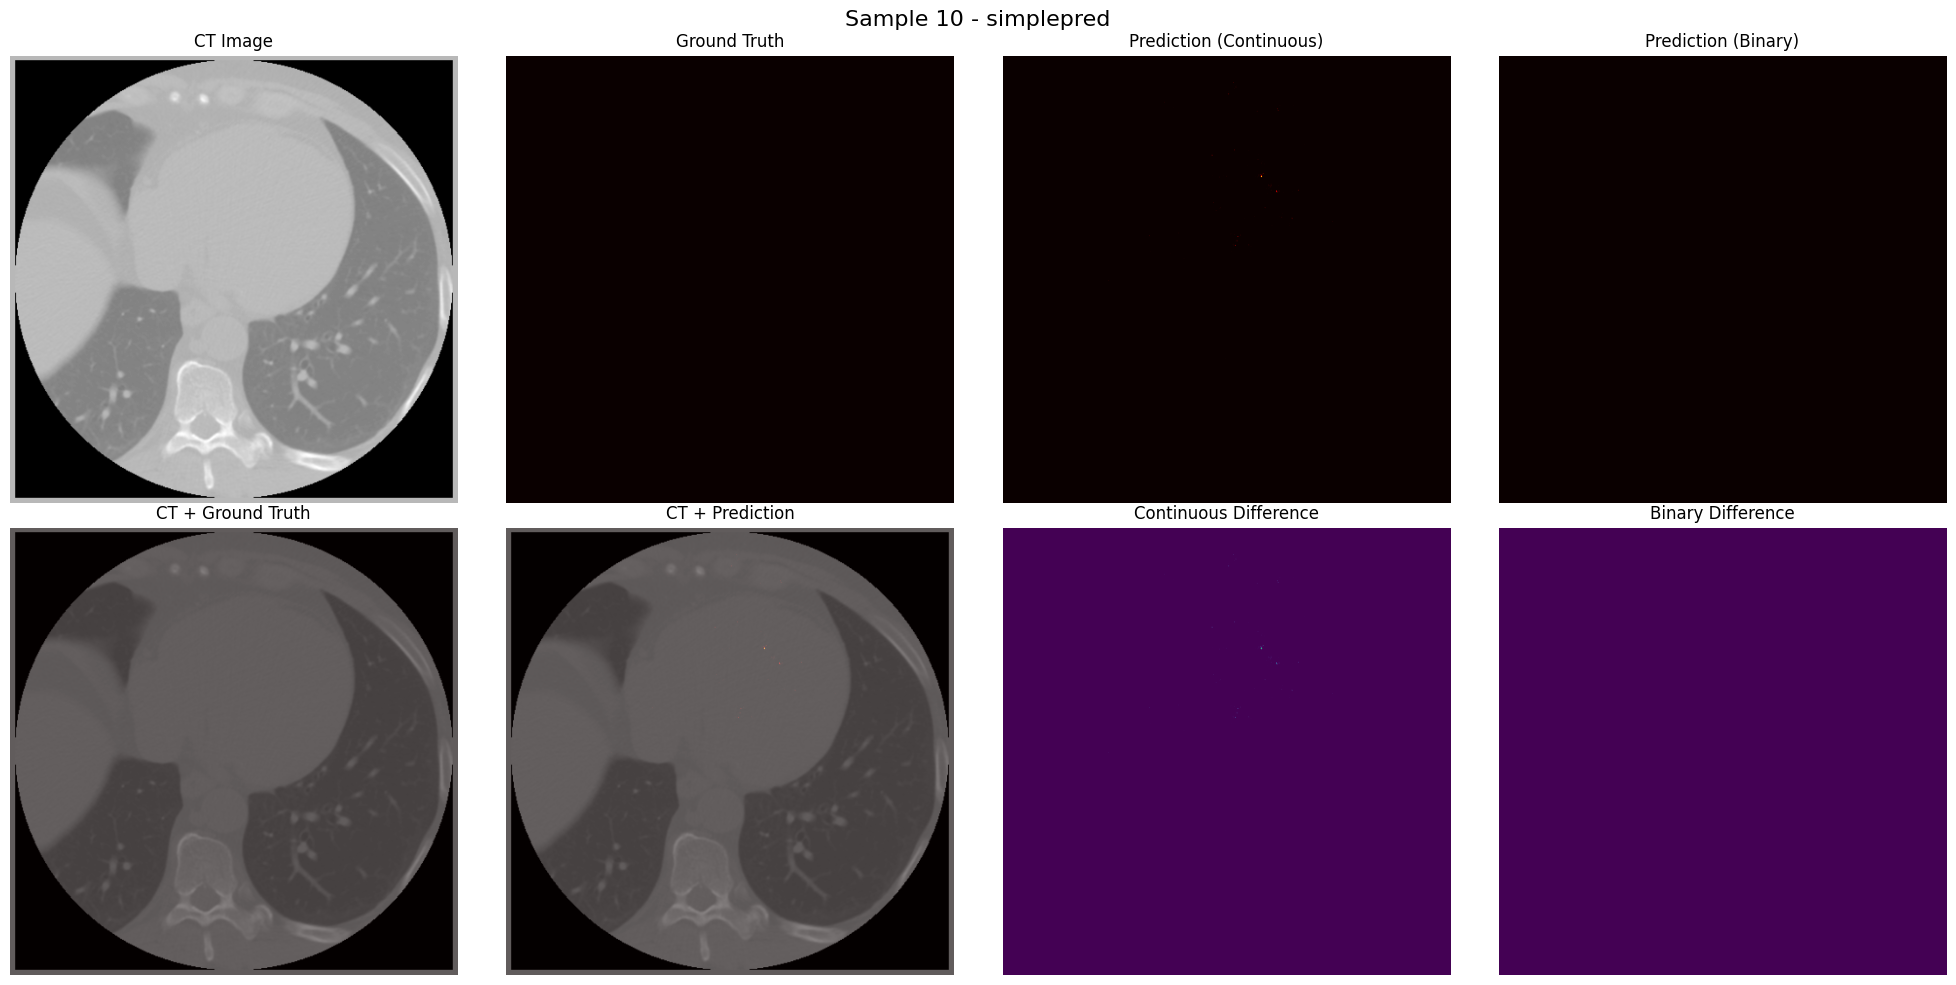

In [14]:
visualize_results(ct_image, true_mask, result, 10, 'simplepred', slice_idx=25)

# Inference

import time
import matplotlib.pyplot as plt
import numpy as np

def inference_step(model, ct_batch, num_timesteps=1000, beta_schedule=None):

    B = ct_batch.shape[0]

    beta_schedule = tf.cast(beta_schedule, tf.float32)
    
    alpha_schedule = 1.0 - beta_schedule
    alpha_bar = tf.math.cumprod(alpha_schedule)
    
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    

    for t in reversed(range(1, num_timesteps)):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            predicted_noise = model([ct_batch, x_t, t_tensor])
        
        beta_t = beta_schedule[t]
        alpha_t = 1.0 - beta_t
        alpha_bar_t = alpha_bar[t]
        alpha_bar_t_prev = alpha_bar[t-1] if t > 0 else tf.constant(1.0, dtype=tf.float32)
        
        coeff1 = 1.0 / tf.sqrt(alpha_t)
        coeff2 = beta_t / tf.sqrt(1.0 - alpha_bar_t)
        
        x_t = coeff1 * (x_t - coeff2 * predicted_noise)
        
        if t > 1:
            beta_tilde = beta_t * (1.0 - alpha_bar_t_prev) / (1.0 - alpha_bar_t)
            sigma_t = tf.sqrt(beta_tilde)
            noise = tf.random.normal(x_t.shape, dtype=tf.float32)
            x_t = x_t + sigma_t * noise
    
    return tf.sigmoid(x_t)

def ddim_inference(model, ct_batch, num_timesteps=1000, beta_schedule=None, eta=0.0, ddim_steps=50):
    """
    DDIM inference - faster deterministic sampling.
    """
    B = ct_batch.shape[0]
    
    # Ensure beta_schedule is float32
    beta_schedule = tf.cast(beta_schedule, tf.float32)
    alpha_schedule = 1.0 - beta_schedule
    alpha_bar = tf.math.cumprod(alpha_schedule)
    
    # Create subset of timesteps for DDIM
    timesteps = np.linspace(0, num_timesteps-1, ddim_steps, dtype=int)
    timesteps = np.flip(timesteps)
    
    # Start with pure noise
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for i, t in enumerate(timesteps[:-1]):
        t_next = timesteps[i + 1]
        
        # Create timestep tensor
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        # Predict noise
        with tf.device('/GPU:0'):
            predicted_noise = model([ct_batch, x_t, t_tensor])
        
        # DDIM update
        alpha_bar_t = alpha_bar[t]
        alpha_bar_t_next = alpha_bar[t_next]
        
        # Predict x_0
        pred_x0 = (x_t - tf.sqrt(1.0 - alpha_bar_t) * predicted_noise) / tf.sqrt(alpha_bar_t)
        
        # Direction to x_t
        dir_xt = tf.sqrt(1.0 - alpha_bar_t_next - eta**2 * (1.0 - alpha_bar_t_next)) * predicted_noise
        
        # Random noise
        noise = tf.random.normal(x_t.shape, dtype=tf.float32) if eta > 0 else 0.0
        
        # Update
        x_t = tf.sqrt(alpha_bar_t_next) * pred_x0 + dir_xt + eta * tf.sqrt(1.0 - alpha_bar_t_next) * noise
    
    return tf.sigmoid(x_t)

def quick_inference(model, ct_batch, timestep=500, beta_schedule=None):
    """
    Quick inference using a single denoising step for faster testing.
    """
    B = ct_batch.shape[0]
    
    beta_schedule = tf.cast(beta_schedule, tf.float32)
    alpha_schedule = 1.0 - beta_schedule
    alpha_bar = tf.math.cumprod(alpha_schedule)
    
    noise = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    alpha_bar_t = alpha_bar[timestep]
    sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
    sqrt_one_minus_alpha_bar_t = tf.sqrt(1.0 - alpha_bar_t)
    
    noisy_input = sqrt_alpha_bar_t * tf.random.normal(ct_batch.shape) + sqrt_one_minus_alpha_bar_t * noise
    
    t_tensor = tf.fill((B,), timestep)
    t_tensor = tf.cast(t_tensor, tf.int32)
    
    with tf.device('/GPU:0'):
        predicted_noise = model([ct_batch, noisy_input, t_tensor])
    
    pred_x0 = (noisy_input - sqrt_one_minus_alpha_bar_t * predicted_noise) / sqrt_alpha_bar_t
    
    return tf.sigmoid(pred_x0)

def test_on_train_gen(model, train_gen, beta_schedule, num_samples=5, use_ddim=True):
    print(f"\n=== Testing Model on {num_samples} Training Samples ===")
    
    total_samples_tested = 0
    all_losses = []
    all_dice_scores = []
    
    for batch_idx, (ct_batch, mask_batch) in enumerate(train_gen):
        if total_samples_tested >= num_samples:
            break
            
        ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
        mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)
        
        if ct_batch.shape[0] == 0:
            continue
            
        B = ct_batch.shape[0]
        for i in range(min(B, num_samples - total_samples_tested)):
            print(f"\nTesting Sample {total_samples_tested + 1}/{num_samples}")

            single_ct = ct_batch[i:i+1]
            single_mask = mask_batch[i:i+1]
            
            print("Performing inference...")
            start_time = time.time()
            
            if use_ddim:
                predicted_mask = ddim_inference(model, single_ct, 1000, beta_schedule, ddim_steps=50)
                method = "DDIM"
            else:
                predicted_mask = inference_step(model, single_ct, 1000, beta_schedule)
                method = "DDPM"
                
            inference_time = time.time() - start_time
            
            loss = tf.keras.losses.binary_crossentropy(single_mask, predicted_mask)
            dice_score = calculate_dice_score(single_mask, predicted_mask)
            iou_score = calculate_iou_score(single_mask, predicted_mask)
            
            print(f"Method: {method}")
            print(f"Inference time: {inference_time:.2f}s")
            print(f"Loss: {tf.reduce_mean(loss).numpy():.4f}")
            print(f"Dice Score: {dice_score:.4f}")
            print(f"IoU Score: {iou_score:.4f}")
            
            all_losses.append(tf.reduce_mean(loss).numpy())
            all_dice_scores.append(dice_score)
            
            visualize_results(single_ct, single_mask, predicted_mask, total_samples_tested + 1)
            total_samples_tested += 1
    

    print(f"\n=== Test Summary ===")
    print(f"Average Loss: {np.mean(all_losses):.4f} ± {np.std(all_losses):.4f}")
    print(f"Average Dice: {np.mean(all_dice_scores):.4f} ± {np.std(all_dice_scores):.4f}")
    print(f"Min/Max Loss: {np.min(all_losses):.4f} / {np.max(all_losses):.4f}")
    print(f"Min/Max Dice: {np.min(all_dice_scores):.4f} / {np.max(all_dice_scores):.4f}")

def calculate_dice_score(y_true, y_pred, threshold=0.5):
    """Calculate Dice coefficient."""
    y_pred_binary = tf.cast(y_pred > threshold, tf.float32)
    y_true_binary = tf.cast(y_true > threshold, tf.float32)
    
    intersection = tf.reduce_sum(y_true_binary * y_pred_binary)
    union = tf.reduce_sum(y_true_binary) + tf.reduce_sum(y_pred_binary)
    
    dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
    return dice.numpy()

def calculate_iou_score(y_true, y_pred, threshold=0.5):
    """Calculate IoU (Intersection over Union) score."""
    y_pred_binary = tf.cast(y_pred > threshold, tf.float32)
    y_true_binary = tf.cast(y_true > threshold, tf.float32)
    
    intersection = tf.reduce_sum(y_true_binary * y_pred_binary)
    union = tf.reduce_sum(y_true_binary) + tf.reduce_sum(y_pred_binary) - intersection
    
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou.numpy()

def visualize_results(ct_image, true_mask, pred_mask, sample_num, slice_idx=None):
    """Visualize CT, true mask, predicted mask, and overlay."""
    if slice_idx is None:
        slice_idx = ct_image.shape[1] // 2  # Middle slice
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Extract slice data
    ct_slice = ct_image[0, slice_idx, :, :, 0].numpy()
    true_slice = true_mask[0, slice_idx, :, :, 0].numpy()
    pred_slice = pred_mask[0, slice_idx, :, :, 0].numpy()
    
    # Top row - individual images
    axes[0, 0].imshow(ct_slice, cmap='gray')
    axes[0, 0].set_title(f'CT Image - Sample {sample_num}')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(true_slice, cmap='gray')
    axes[0, 1].set_title('Ground Truth Mask')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(pred_slice, cmap='gray')
    axes[0, 2].set_title('Predicted Mask')
    axes[0, 2].axis('off')
    
    # Bottom row - overlays
    axes[1, 0].imshow(ct_slice, cmap='gray')
    axes[1, 0].imshow(true_slice, cmap='gray', alpha=0.5)
    axes[1, 0].set_title('CT + Ground Truth')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(ct_slice, cmap='gray')
    axes[1, 1].imshow(pred_slice, cmap='gray', alpha=0.5)
    axes[1, 1].set_title('CT + Prediction')
    axes[1, 1].axis('off')
    
    # Difference map
    diff = np.abs(true_slice - pred_slice)
    axes[1, 2].imshow(diff, cmap='viridis')
    axes[1, 2].set_title('Absolute Difference')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


test_on_train_gen(model, train_gen, beta_schedule, num_samples=3, use_ddim=True)




 Test with full DDPM 
test_on_train_gen(model, train_gen, beta_schedule, num_samples=6, use_ddim=False)

 for batch_idx, (ct_batch, mask_batch) in enumerate(train_gen):
     if batch_idx >= 1:  
         break
        
    ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
    mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)
    
    if ct_batch.shape[0] == 0:
         continue
    
  
     pred_mask = quick_inference(model, ct_batch, timestep=500, beta_schedule=beta_schedule)
    
 
     dice = calculate_dice_score(mask_batch, pred_mask)
     iou = calculate_iou_score(mask_batch, pred_mask)
    
     print(f"Quick test - Dice: {dice:.4f}, IoU: {iou:.4f}")
    
 
     if ct_batch.shape[0] > 0:
         visualize_results(ct_batch[0:1], mask_batch[0:1], pred_mask[0:1], 1)


# Inference 2

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


def deterministic_autoregressive_inference(model, ct_batch, num_timesteps=1):
    B = ct_batch.shape[0]
    
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in tqdm(reversed(range(1, num_timesteps)), desc="Deterministic Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            x_t_minus_1 = model([ct_batch, x_t, t_tensor])
        

        x_t = tf.clip_by_value(x_t_minus_1, 0.0, 1.0)
    
    return x_t

def fast_autoregressive_inference(model, ct_batch, num_steps=10):

    B = ct_batch.shape[0]
    timesteps = np.linspace(1, 1000, num_steps, dtype=int)
    timesteps = np.flip(timesteps)
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in tqdm(timesteps, desc="Fast Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            x_t_minus_1 = model([ct_batch, x_t, t_tensor])
        
        x_t = tf.clip_by_value(x_t_minus_1, 0.0, 1.0)
    
    return x_t

def single_step_inference(model, ct_batch, timestep=1000):
    B = ct_batch.shape[0]
    
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    t_tensor = tf.fill((B,), timestep)
    t_tensor = tf.cast(t_tensor, tf.int32)
    
    with tf.device('/GPU:0'):
        predicted_mask = model([ct_batch, x_t, t_tensor])
    
    return tf.clip_by_value(predicted_mask, 0.0, 1.0)

def calculate_dice_score(y_true, y_pred, threshold=0.5):
    y_pred_binary = tf.cast(y_pred > threshold, tf.float32)
    y_true_binary = tf.cast(y_true > threshold, tf.float32)
    
    intersection = tf.reduce_sum(y_true_binary * y_pred_binary)
    union = tf.reduce_sum(y_true_binary) + tf.reduce_sum(y_pred_binary)
    
    dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
    return dice.numpy()

def calculate_iou_score(y_true, y_pred, threshold=0.5):
    y_pred_binary = tf.cast(y_pred > threshold, tf.float32)
    y_true_binary = tf.cast(y_true > threshold, tf.float32)
    
    intersection = tf.reduce_sum(y_true_binary * y_pred_binary)
    union = tf.reduce_sum(y_true_binary) + tf.reduce_sum(y_pred_binary) - intersection
    
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou.numpy()

def calculate_hausdorff_distance(y_true, y_pred, threshold=0.5):
    y_pred_binary = tf.cast(y_pred > threshold, tf.float32)
    y_true_binary = tf.cast(y_true > threshold, tf.float32)
    
    diff = tf.abs(y_true_binary - y_pred_binary)
    hd = tf.reduce_mean(diff)
    
    return hd.numpy()

def visualize_results(ct_image, true_mask, pred_mask, sample_num, method_name, slice_idx=None):
    """Visualize results with method name."""
    if slice_idx is None:
        slice_idx = ct_image.shape[1] // 2
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Sample {sample_num} - {method_name}', fontsize=16)
    
    # Extract slice data
    ct_slice = ct_image[0, slice_idx, :, :, 0].numpy()
    true_slice = true_mask[0, slice_idx, :, :, 0].numpy()
    pred_slice = pred_mask[0, slice_idx, :, :, 0].numpy()
    pred_binary = (pred_slice > 0.5).astype(np.float32)
    
    # Top row
    axes[0, 0].imshow(ct_slice, cmap='gray')
    axes[0, 0].set_title('CT Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(true_slice, cmap='hot')
    axes[0, 1].set_title('Ground Truth')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(pred_slice, cmap='hot')
    axes[0, 2].set_title('Prediction (Continuous)')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(pred_binary, cmap='hot')
    axes[0, 3].set_title('Prediction (Binary)')
    axes[0, 3].axis('off')
    
    # Bottom row - overlays
    axes[1, 0].imshow(ct_slice, cmap='gray')
    axes[1, 0].imshow(true_slice, cmap='hot', alpha=0.5)
    axes[1, 0].set_title('CT + Ground Truth')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(ct_slice, cmap='gray')
    axes[1, 1].imshow(pred_slice, cmap='hot', alpha=0.5)
    axes[1, 1].set_title('CT + Prediction')
    axes[1, 1].axis('off')
    
    # Difference maps
    diff_continuous = np.abs(true_slice - pred_slice)
    axes[1, 2].imshow(diff_continuous, cmap='viridis')
    axes[1, 2].set_title('Continuous Difference')
    axes[1, 2].axis('off')
    
    diff_binary = np.abs(true_slice - pred_binary)
    axes[1, 3].imshow(diff_binary, cmap='viridis')
    axes[1, 3].set_title('Binary Difference')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_slices(ct_image, true_mask, pred_mask, sample_num, method_name, num_slices=5):
    """Visualize multiple slices."""
    depth = ct_image.shape[1]
    slice_indices = np.linspace(depth//4, 3*depth//4, num_slices, dtype=int)
    
    fig, axes = plt.subplots(3, num_slices, figsize=(4*num_slices, 12))
    fig.suptitle(f'Sample {sample_num} - {method_name} - Multiple Slices', fontsize=16)
    
    for i, slice_idx in enumerate(slice_indices):
        ct_slice = ct_image[0, slice_idx, :, :, 0].numpy()
        true_slice = true_mask[0, slice_idx, :, :, 0].numpy()
        pred_slice = pred_mask[0, slice_idx, :, :, 0].numpy()
        
        axes[0, i].imshow(ct_slice, cmap='gray')
        axes[0, i].set_title(f'CT Slice {slice_idx}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(true_slice, cmap='hot')
        axes[1, i].set_title(f'Ground Truth')
        axes[1, i].axis('off')
        
        axes[2, i].imshow(pred_slice, cmap='hot')
        axes[2, i].set_title(f'Prediction')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def comprehensive_test_model(model, train_gen, beta_schedule=None, num_samples=5):
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE MODEL TESTING - {num_samples} SAMPLES")
    print(f"{'='*60}")
    
    inference_methods = [
        ("Single Step", lambda ct: single_step_inference(model, ct, timestep=999)),
        ("Fast (50 steps)", lambda ct: fast_autoregressive_inference(model, ct, num_steps=10)),
        ("Medium (200 steps)", lambda ct: fast_autoregressive_inference(model, ct, num_steps=100)),
        ("Full (1000 steps)", lambda ct: deterministic_autoregressive_inference(model, ct, 10))
    ]

    results = {method[0]: {'times': [], 'dice': [], 'iou': [], 'hd': []} for method in inference_methods}
    
    total_samples_tested = 0
    
    for batch_idx, (ct_batch, mask_batch) in enumerate(train_gen):
        if total_samples_tested >= num_samples:
            break
            
        ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
        mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)
        
        if ct_batch.shape[0] == 0:
            continue
            
        B = ct_batch.shape[0]
        
        for i in range(min(B, num_samples - total_samples_tested)):
            sample_num = total_samples_tested + 1
            print(f"\n{'-'*50}")
            print(f"TESTING SAMPLE {sample_num}/{num_samples}")
            print(f"{'-'*50}")
            
            single_ct = ct_batch[i:i+1]
            single_mask = mask_batch[i:i+1]
            
            for method_name, inference_fn in inference_methods:
                print(f"\n--- {method_name} ---")
                
                start_time = time.time()
                try:
                    predicted_mask = inference_fn(single_ct)
                    inference_time = time.time() - start_time
                    
                    loss = tf.keras.losses.binary_crossentropy(single_mask, predicted_mask)
                    dice_score = calculate_dice_score(single_mask, predicted_mask)
                    iou_score = calculate_iou_score(single_mask, predicted_mask)
                    hd_score = calculate_hausdorff_distance(single_mask, predicted_mask)
                    
                    results[method_name]['times'].append(inference_time)
                    results[method_name]['dice'].append(dice_score)
                    results[method_name]['iou'].append(iou_score)
                    results[method_name]['hd'].append(hd_score)
                    
                    print(f"Inference time: {inference_time:.2f}s")
                    print(f"Loss: {tf.reduce_mean(loss).numpy():.4f}")
                    print(f"Dice Score: {dice_score:.4f}")
                    print(f"IoU Score: {iou_score:.4f}")
                    print(f"Hausdorff Distance: {hd_score:.4f}")
                    
                    if method_name == "Fast (50 steps)":
                        visualize_results(single_ct, single_mask, predicted_mask, 
                                        sample_num, method_name)
                        
                        if sample_num == 1:
                            visualize_multiple_slices(single_ct, single_mask, predicted_mask,
                                                    sample_num, method_name)
                
                except Exception as e:
                    print(f"Error in {method_name}: {e}")
                    continue
            
            total_samples_tested += 1
    
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS")
    print(f"{'='*60}")
    
    for method_name in results.keys():
        if results[method_name]['dice']: 
            print(f"\n{method_name}:")
            print(f"  Average Time: {np.mean(results[method_name]['times']):.2f}s ± {np.std(results[method_name]['times']):.2f}s")
            print(f"  Average Dice: {np.mean(results[method_name]['dice']):.4f} ± {np.std(results[method_name]['dice']):.4f}")
            print(f"  Average IoU:  {np.mean(results[method_name]['iou']):.4f} ± {np.std(results[method_name]['iou']):.4f}")
            print(f"  Average HD:   {np.mean(results[method_name]['hd']):.4f} ± {np.std(results[method_name]['hd']):.4f}")
            print(f"  Min/Max Dice: {np.min(results[method_name]['dice']):.4f} / {np.max(results[method_name]['dice']):.4f}")
    
    return results

def quick_test_model(model, train_gen, num_samples=3):
    """
    Quick test for debugging.
    """
    print(f"\n{'='*40}")
    print(f"QUICK MODEL TEST - {num_samples} SAMPLES")
    print(f"{'='*40}")
    
    total_samples_tested = 0
    
    for batch_idx, (ct_batch, mask_batch) in enumerate(train_gen):
        if total_samples_tested >= num_samples:
            break
            
        ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
        mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)
        
        if ct_batch.shape[0] == 0:
            continue
            
        B = ct_batch.shape[0]
        
        for i in range(min(B, num_samples - total_samples_tested)):
            sample_num = total_samples_tested + 1
            print(f"\nQuick Test Sample {sample_num}/{num_samples}")
            
            single_ct = ct_batch[i:i+1]
            single_mask = mask_batch[i:i+1]
            
            start_time = time.time()
            pred_mask = single_step_inference(model, single_ct, timestep=500)
            inference_time = time.time() - start_time
            
            dice = calculate_dice_score(single_mask, pred_mask)
            iou = calculate_iou_score(single_mask, pred_mask)
            
            print(f"Time: {inference_time:.2f}s, Dice: {dice:.4f}, IoU: {iou:.4f}")
            
            total_samples_tested += 1


In [16]:


beta_schedule = np.linspace(1e-4, 0.02, 10).astype(np.float32)


quick_test_model(model, train_gen, num_samples=1)


results = comprehensive_test_model(model, val_gen, beta_schedule, num_samples=5)




QUICK MODEL TEST - 1 SAMPLES

Quick Test Sample 1/1
Time: 0.35s, Dice: 0.6875, IoU: 0.5238

COMPREHENSIVE MODEL TESTING - 5 SAMPLES

--------------------------------------------------
TESTING SAMPLE 1/5
--------------------------------------------------

--- Single Step ---
Inference time: 0.36s
Loss: 0.0000
Dice Score: 0.4706
IoU Score: 0.3077
Hausdorff Distance: 0.0000

--- Fast (50 steps) ---


KeyboardInterrupt: 

# Noisy inference


NOISY INFERENCE METHODS COMPARISON - 10 SAMPLES

--------------------------------------------------
TESTING SAMPLE 1/10
--------------------------------------------------

--- No Noise - Single Step(Baseline) ---
Time: 0.46s
Dice: 0.7273
IoU: 0.5714

--- Fixed Noise (0.1) ---


Time: 0.88s
Dice: 0.6667
IoU: 0.5000

--- Adaptive Noise ---


Time: 0.87s
Dice: 0.6667
IoU: 0.5000


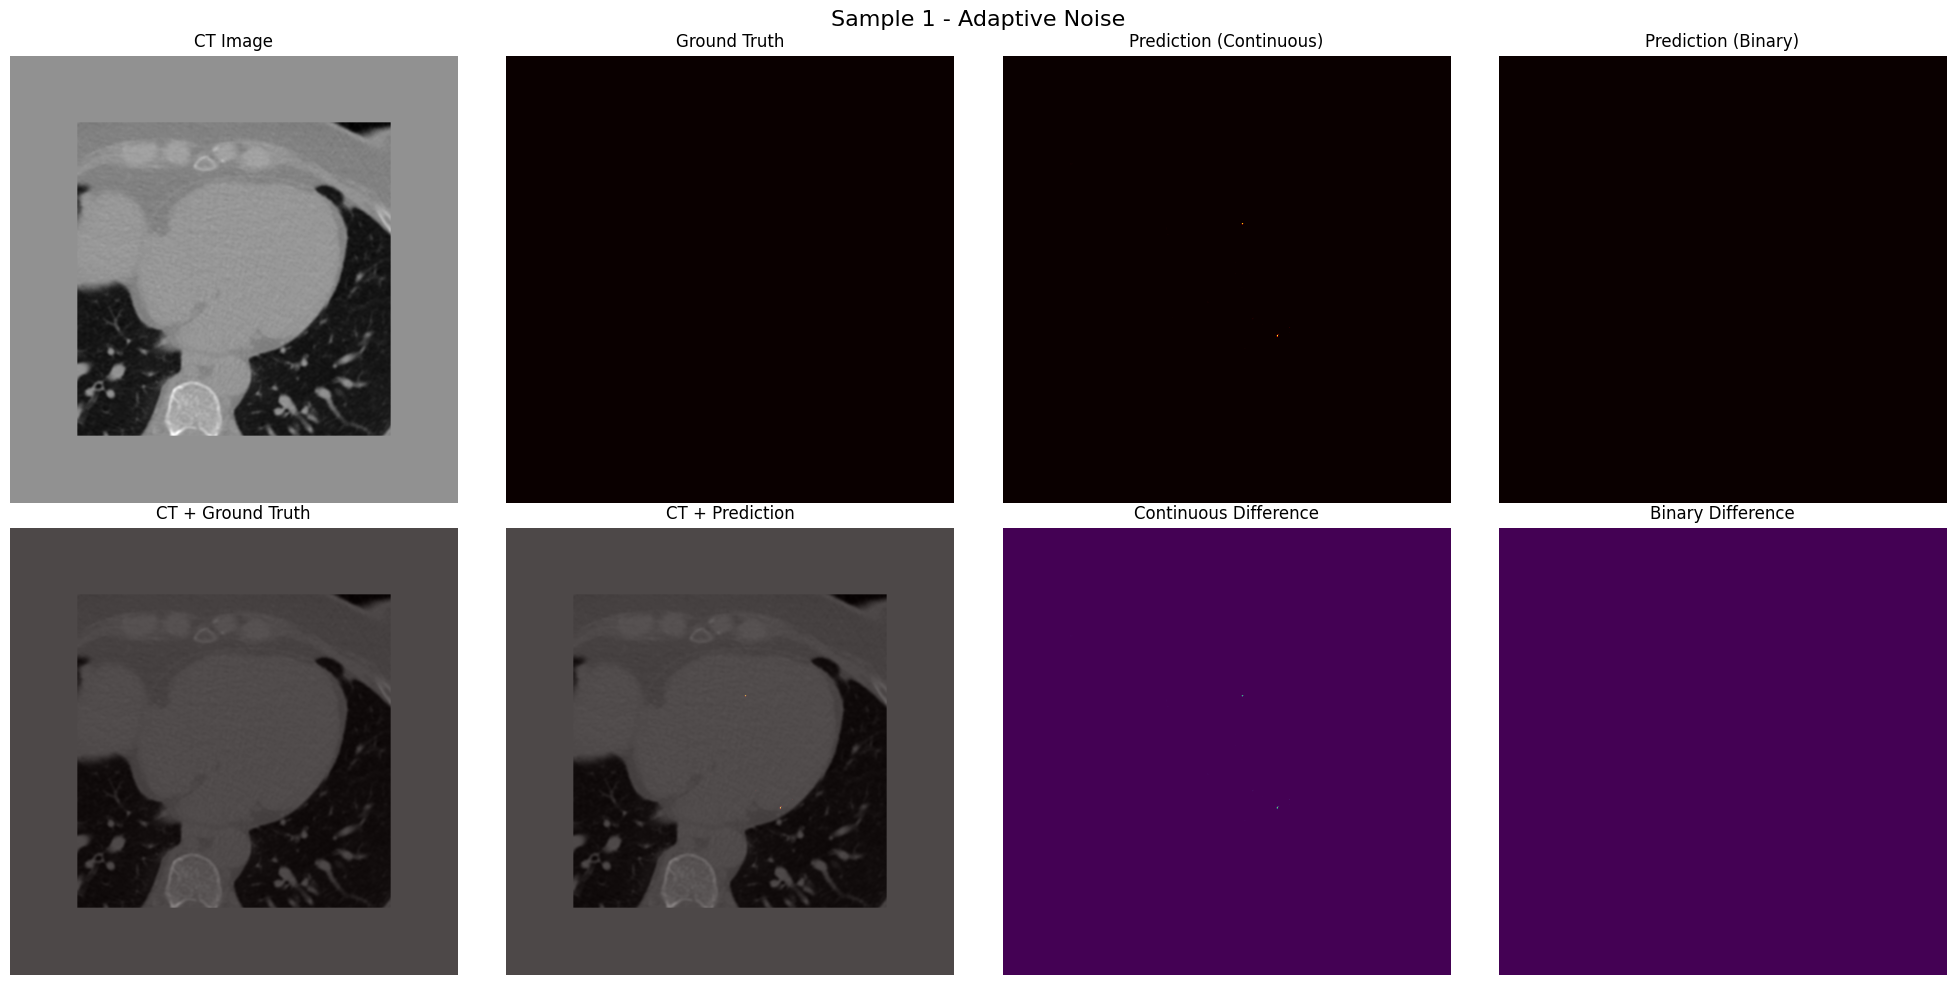


--- Progressive Noise ---


Time: 0.88s
Dice: 0.6667
IoU: 0.5000

--- Confidence-Based ---


Time: 0.84s
Dice: 0.6667
IoU: 0.5000

--------------------------------------------------
TESTING SAMPLE 2/10
--------------------------------------------------

--- No Noise - Single Step(Baseline) ---
Time: 0.04s
Dice: 0.0000
IoU: 0.0000

--- Fixed Noise (0.1) ---


Time: 0.86s
Dice: 0.0000
IoU: 0.0000

--- Adaptive Noise ---


Time: 0.86s
Dice: 0.0000
IoU: 0.0000


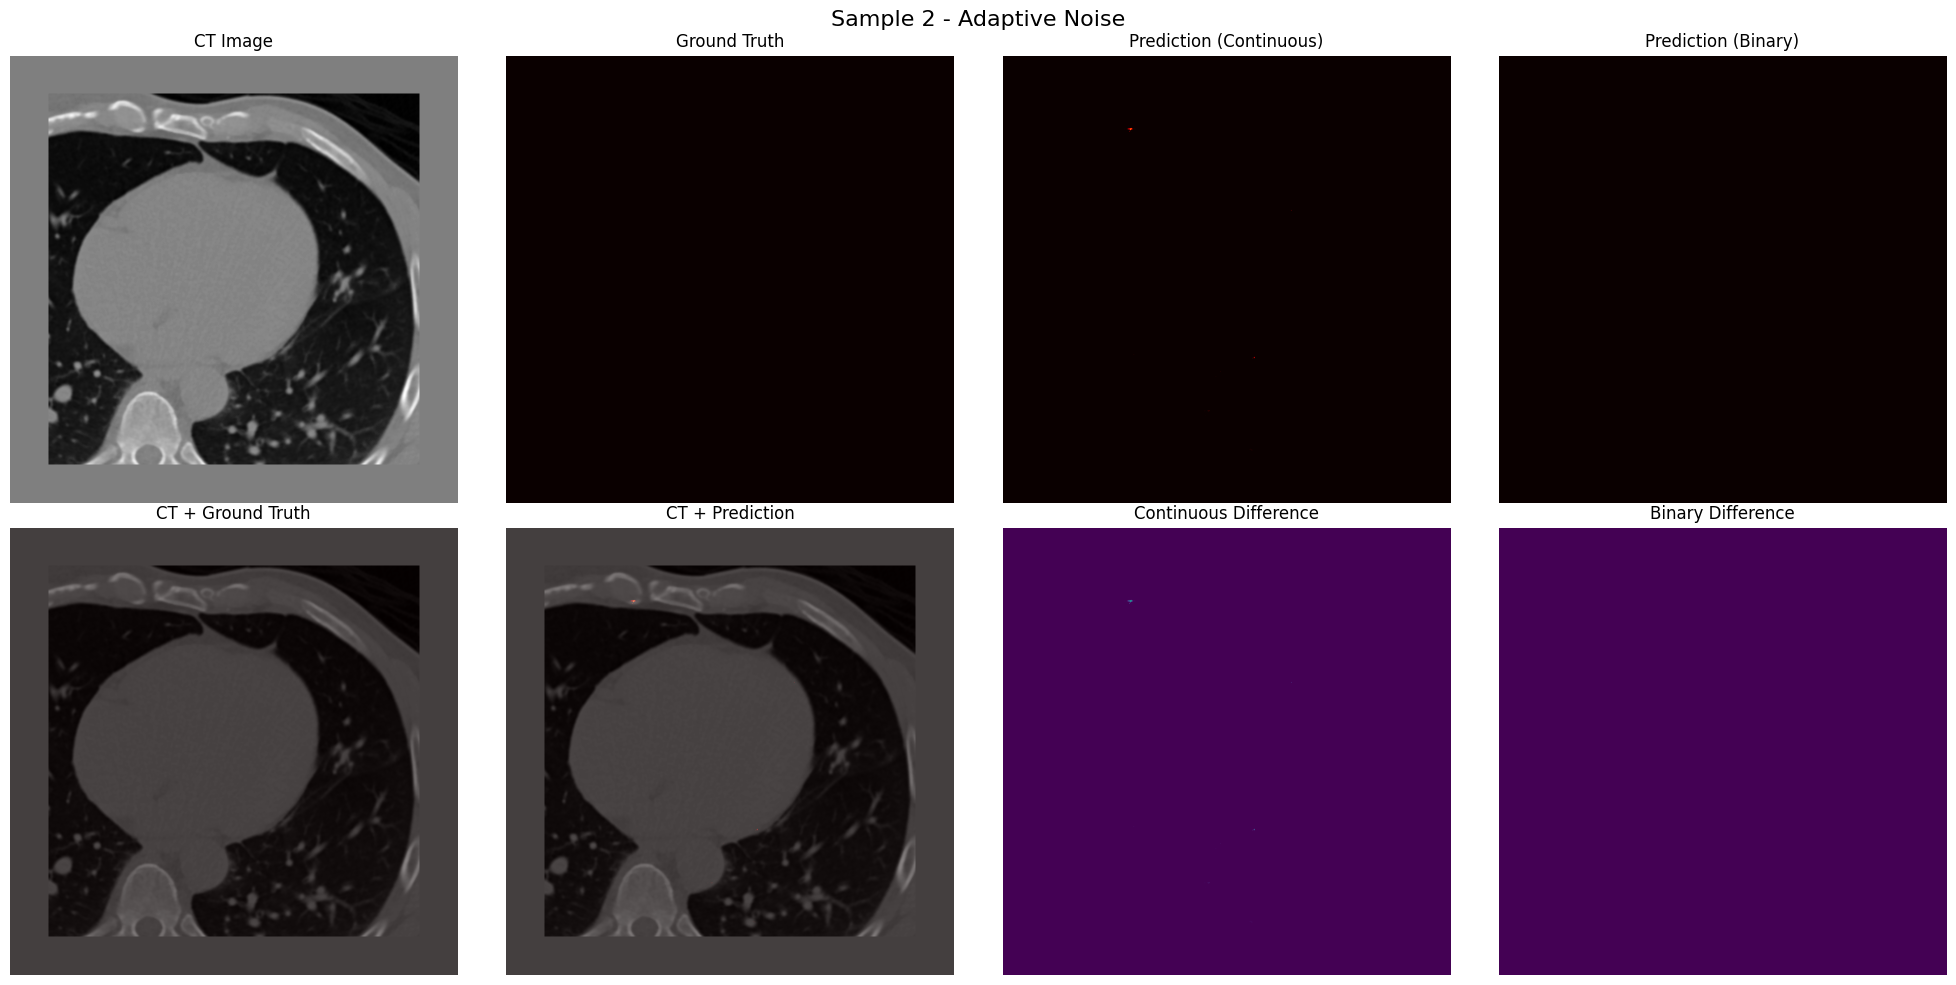


--- Progressive Noise ---


KeyboardInterrupt: 

In [15]:

import tensorflow as tf
import numpy as np
from tqdm import tqdm
import time
def noisy_feedback_inference(model, ct_batch, num_timesteps=10, beta_schedule=None, noise_scale=0.1):
    B = ct_batch.shape[0]
    
    beta_schedule = tf.cast(beta_schedule, tf.float32)
    alpha_schedule = 1.0 - beta_schedule
    alpha_bar = tf.math.cumprod(alpha_schedule)
    
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in tqdm(reversed(range(1, num_timesteps)), desc="Noisy Feedback Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            predicted_mask = model([ct_batch, x_t, t_tensor])

        if t > 1: 
    
            current_noise_scale = noise_scale * (t / num_timesteps)
            noise = tf.random.normal(predicted_mask.shape, dtype=tf.float32)
            x_t = predicted_mask + current_noise_scale * noise
        else:
            x_t = predicted_mask
        
        x_t = tf.clip_by_value(x_t, 0.0, 1.0)
    
    return x_t

def adaptive_noise_inference(model, ct_batch, num_timesteps=10, beta_schedule=None):
    """
    Inference with adaptive noise based on diffusion schedule.
    Uses the actual beta schedule to determine noise amount.
    """
    B = ct_batch.shape[0]
    
    beta_schedule = tf.cast(beta_schedule, tf.float32)
    alpha_schedule = 1.0 - beta_schedule
    alpha_bar = tf.math.cumprod(alpha_schedule)

    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in tqdm(reversed(range(1, num_timesteps)), desc="Adaptive Noise Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            predicted_mask = model([ct_batch, x_t, t_tensor])
        
        if t > 1:

            beta_t = beta_schedule[t-1] 
            noise_variance = tf.sqrt(beta_t)
            
            noise = tf.random.normal(predicted_mask.shape, dtype=tf.float32)
            x_t = predicted_mask + noise_variance * noise
        else:
            x_t = predicted_mask
        
        x_t = tf.clip_by_value(x_t, 0.0, 1.0)
    
    return x_t

def progressive_noise_reduction_inference(model, ct_batch, num_timesteps=10, 
                                        initial_noise=0.3, final_noise=0.01):
    """
    Inference with progressively reducing noise addition.
    Starts with high noise and gradually reduces it.
    """
    B = ct_batch.shape[0]
    
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for step, t in enumerate(tqdm(reversed(range(1, num_timesteps)), 
                                 desc="Progressive Noise Inference", leave=False)):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            predicted_clean_mask = model([ct_batch, x_t, t_tensor])
        
        if t > 1:
            progress = step / (num_timesteps - 1)
            current_noise_scale = initial_noise * (1 - progress) + final_noise * progress
            
            noise = tf.random.normal(predicted_clean_mask.shape, dtype=tf.float32)
            x_t = predicted_clean_mask + current_noise_scale * noise
        else:
            x_t = predicted_clean_mask
        
        x_t = tf.clip_by_value(x_t, 0.0, 1.0)
    
    return x_t

def confidence_based_noise_inference(model, ct_batch, num_timesteps=10, 
                                    base_noise=0.1, confidence_threshold=0.8):

    B = ct_batch.shape[0]
    
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in tqdm(reversed(range(1, num_timesteps)), desc="Confidence-Based Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            predicted_clean_mask = model([ct_batch, x_t, t_tensor])
        
        if t > 1:

            confidence = tf.reduce_mean(tf.abs(predicted_clean_mask - 0.5) * 2)
            


            if confidence < confidence_threshold:
                noise_scale = base_noise * (1 - confidence)
            else:
                noise_scale = base_noise * 0.1 
            
            noise = tf.random.normal(predicted_clean_mask.shape, dtype=tf.float32)
            x_t = predicted_clean_mask + noise_scale * noise
        else:
            x_t = predicted_clean_mask
        
        x_t = tf.clip_by_value(x_t, 0.0, 1.0)
    
    return x_t

def comprehensive_noisy_inference_test(model, train_gen, beta_schedule=None, num_samples=3):
    print(f"\n{'='*60}")
    print(f"NOISY INFERENCE METHODS COMPARISON - {num_samples} SAMPLES")
    print(f"{'='*60}")
    
    inference_methods = [
        ("No Noise - Single Step(Baseline)", lambda ct: single_step_inference(model, ct, timestep=999)),
        ("Fixed Noise (0.1)", lambda ct: noisy_feedback_inference(model, ct, 5, beta_schedule, 0.1)),
        ("Adaptive Noise", lambda ct: adaptive_noise_inference(model, ct, 5, beta_schedule)),
        ("Progressive Noise", lambda ct: progressive_noise_reduction_inference(model, ct, 5, 0.3, 0.01)),
        ("Confidence-Based", lambda ct: confidence_based_noise_inference(model, ct, 5, 0.1, 0.8))
    ]
    
    results = {method[0]: {'dice': [], 'iou': []} for method in inference_methods}
    
    total_samples_tested = 0
    
    for batch_idx, (ct_batch, mask_batch) in enumerate(train_gen):
        if total_samples_tested >= num_samples:
            break
            
        ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
        mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)
        
        if ct_batch.shape[0] == 0:
            continue
            
        B = ct_batch.shape[0]
        
        for i in range(min(B, num_samples - total_samples_tested)):
            sample_num = total_samples_tested + 1
            print(f"\n{'-'*50}")
            print(f"TESTING SAMPLE {sample_num}/{num_samples}")
            print(f"{'-'*50}")
            
            single_ct = ct_batch[i:i+1]
            single_mask = mask_batch[i:i+1]
            
            for method_name, inference_fn in inference_methods:
                print(f"\n--- {method_name} ---")
                
                try:
                    start_time = time.time()
                    predicted_mask = inference_fn(single_ct)
                    inference_time = time.time() - start_time
                    
                    dice_score = calculate_dice_score(single_mask, predicted_mask)
                    iou_score = calculate_iou_score(single_mask, predicted_mask)
                    
                    results[method_name]['dice'].append(dice_score)
                    results[method_name]['iou'].append(iou_score)
                    
                    print(f"Time: {inference_time:.2f}s")
                    print(f"Dice: {dice_score:.4f}")
                    print(f"IoU: {iou_score:.4f}")
                    
                    if method_name == "Adaptive Noise":
                        visualize_results(single_ct, single_mask, predicted_mask, 
                                        sample_num, method_name)
                
                except Exception as e:
                    print(f"Error in {method_name}: {e}")
                    continue
            
            total_samples_tested += 1
    

    print(f"\n{'='*60}")
    print("METHOD COMPARISON SUMMARY")
    print(f"{'='*60}")
    
    for method_name in results.keys():
        if results[method_name]['dice']:
            avg_dice = np.mean(results[method_name]['dice'])
            avg_iou = np.mean(results[method_name]['iou'])
            print(f"\n{method_name}:")
            print(f"  Average Dice: {avg_dice:.4f}")
            print(f"  Average IoU:  {avg_iou:.4f}")
    
    return results

def deterministic_autoregressive_inference(model, ct_batch, num_timesteps):
    """Baseline inference without noise addition."""
    B = ct_batch.shape[0]
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in reversed(range(1, num_timesteps)):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            x_t_minus_1 = model([ct_batch, x_t, t_tensor])
        
        x_t = tf.clip_by_value(x_t_minus_1, 0.0, 1.0)
    
    return x_t

if __name__ == "__main__":

    results = comprehensive_noisy_inference_test(model, val_gen, beta_schedule, num_samples=10)
    

In [12]:
model = tf.keras.models.load_model(
    "/home/cds/Documents/Adithya/cac_segmentation_diffatt_v9.keras",
    custom_objects={'TimestepEmbedding': TimestepEmbedding, 'SelfAttention3D':SelfAttention3D,'MCDropout':MCDropout},
    compile=False
)


In [16]:
import time
import tensorflow as tf
import numpy as np
from tqdm import tqdm

def noisy_feedback_inference(model, ct_batch, num_timesteps=10, beta_schedule=None, noise_scale=0.1):
    B = ct_batch.shape[0]
    

    beta_schedule = tf.cast(beta_schedule, tf.float32)
    alpha_schedule = 1.0 - beta_schedule
    alpha_bar = tf.math.cumprod(alpha_schedule)
    

    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in tqdm(reversed(range(1, num_timesteps)), desc="Noisy Feedback Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
 
        with tf.device('/GPU:0'):
            predicted_clean_mask = model([ct_batch, x_t, t_tensor])

        if t > 1: 
    
            current_noise_scale = noise_scale * (t / num_timesteps)
            noise = tf.random.normal(predicted_clean_mask.shape, dtype=tf.float32)
            x_t = predicted_clean_mask + current_noise_scale * noise
        else:
            x_t = predicted_clean_mask
        
        x_t = tf.clip_by_value(x_t, 0.0, 1.0)
    
    return x_t

def adaptive_noise_inference(model, ct_batch, num_timesteps=10, beta_schedule=None):
    """
    Inference with adaptive noise based on diffusion schedule.
    Uses the actual beta schedule to determine noise amount.
    """
    B = ct_batch.shape[0]
    
    beta_schedule = tf.cast(beta_schedule, tf.float32)
    alpha_schedule = 1.0 - beta_schedule
    alpha_bar = tf.math.cumprod(alpha_schedule)
    
    # Start with pure noise
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in tqdm(reversed(range(1, num_timesteps)), desc="Adaptive Noise Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            predicted_clean_mask = model([ct_batch, x_t, t_tensor])
        
        if t > 1:

            beta_t = beta_schedule[t-1] 
            noise_variance = tf.sqrt(beta_t)
            
            noise = tf.random.normal(predicted_clean_mask.shape, dtype=tf.float32)
            x_t = predicted_clean_mask + noise_variance * noise
        else:
            x_t = predicted_clean_mask
        
        x_t = tf.clip_by_value(x_t, 0.0, 1.0)
    
    return x_t

def progressive_noise_reduction_inference(model, ct_batch, num_timesteps=10, 
                                        initial_noise=0.3, final_noise=0.01):
    """
    Inference with progressively reducing noise addition.
    Starts with high noise and gradually reduces it.
    """
    B = ct_batch.shape[0]
    
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for step, t in enumerate(tqdm(reversed(range(1, num_timesteps)), 
                                 desc="Progressive Noise Inference", leave=False)):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            predicted_clean_mask = model([ct_batch, x_t, t_tensor])
        
        if t > 1:
            progress = step / (num_timesteps - 1)
            current_noise_scale = initial_noise * (1 - progress) + final_noise * progress
            
            noise = tf.random.normal(predicted_clean_mask.shape, dtype=tf.float32)
            x_t = predicted_clean_mask + current_noise_scale * noise
        else:
            x_t = predicted_clean_mask
        
        x_t = tf.clip_by_value(x_t, 0.0, 1.0)
    
    return x_t

def confidence_based_noise_inference(model, ct_batch, num_timesteps=10, 
                                    base_noise=0.1, confidence_threshold=0.8):
    """
    Inference where noise is added based on prediction confidence.
    More noise for uncertain predictions, less for confident ones.
    """
    B = ct_batch.shape[0]
    
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in tqdm(reversed(range(1, num_timesteps)), desc="Confidence-Based Inference", leave=False):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            predicted_clean_mask = model([ct_batch, x_t, t_tensor])
        
        if t > 1:

            confidence = tf.reduce_mean(tf.abs(predicted_clean_mask - 0.5) * 2)
            

            if confidence < confidence_threshold:
                noise_scale = base_noise * (1 - confidence)
            else:
                noise_scale = base_noise * 0.1 
            
            noise = tf.random.normal(predicted_clean_mask.shape, dtype=tf.float32)
            x_t = predicted_clean_mask + noise_scale * noise
        else:
            x_t = predicted_clean_mask
        
        x_t = tf.clip_by_value(x_t, 0.0, 1.0)
    
    return x_t

def comprehensive_noisy_inference_test(model, train_gen, beta_schedule=None, num_samples=3):
    """
    Test all noisy inference methods and compare results.
    """
    # print(f"\n{'='*60}")
    # print(f"NOISY INFERENCE METHODS COMPARISON - {num_samples} SAMPLES")
    # print(f"{'='*60}")
    
    inference_methods = [
        ("Single Step Noise (Baseline)", lambda ct: single_step_inference(model, ct, timestep=1000)),
       # ("Fixed Noise (0.1)", lambda ct: noisy_feedback_inference(model, ct, 5, beta_schedule, 0.1)),
       # ("Adaptive Noise", lambda ct: adaptive_noise_inference(model, ct, 5, beta_schedule)),
       # ("Progressive Noise", lambda ct: progressive_noise_reduction_inference(model, ct, 5, 0.3, 0.01)),
       # ("Confidence-Based", lambda ct: confidence_based_noise_inference(model, ct, 5, 0.1, 0.8))
    ]
    
    results = {method[0]: {'dice': [], 'iou': []} for method in inference_methods}
    
    total_samples_tested = 0
    
    for batch_idx, (ct_batch, mask_batch) in tqdm(enumerate(train_gen)):
        if total_samples_tested >= num_samples:
            break
            
        ct_batch = tf.convert_to_tensor(ct_batch, dtype=tf.float32)
        mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)
        
        if ct_batch.shape[0] == 0:
            continue
            
        B = ct_batch.shape[0]
        
        for i in range(min(B, num_samples - total_samples_tested)):
            sample_num = total_samples_tested + 1
            # print(f"\n{'-'*50}")
            # print(f"TESTING SAMPLE {sample_num}/{num_samples}")
            # print(f"{'-'*50}")
            
            single_ct = ct_batch[i:i+1]
            single_mask = mask_batch[i:i+1]
            
            for method_name, inference_fn in inference_methods:
                #print(f"\n--- {method_name} ---")
                
                try:
                    start_time = time.time()
                    predicted_mask = inference_fn(single_ct)
                    inference_time = time.time() - start_time
                    
                    dice_score = calculate_dice_score(single_mask, predicted_mask)
                    iou_score = calculate_iou_score(single_mask, predicted_mask)
                    
                    results[method_name]['dice'].append(dice_score)
                    results[method_name]['iou'].append(iou_score)
                    
                    # print(f"Time: {inference_time:.2f}s")
                    # print(f"Dice: {dice_score:.4f}")
                    # print(f"IoU: {iou_score:.4f}")
                    
                    # if method_name == "Adaptive Noise":
                    #     visualize_results(single_ct, single_mask, predicted_mask, 
                    #                     sample_num, method_name)
                
                except Exception as e:
                    print(f"Error in {method_name}: {e}")
                    continue
            
            total_samples_tested += 1
    

    print(f"\n{'='*60}")
    print("METHOD COMPARISON SUMMARY")
    print(f"{'='*60}")
    
    for method_name in results.keys():
        if results[method_name]['dice']:
            avg_dice = np.mean(results[method_name]['dice'])
            avg_iou = np.mean(results[method_name]['iou'])
            print(f"\n{method_name}:")
            print(f"  Average Dice: {avg_dice:.4f}")
            print(f"  Average IoU:  {avg_iou:.4f}")
    
    return results

def deterministic_autoregressive_inference(model, ct_batch, num_timesteps):
    """Baseline inference without noise addition."""
    B = ct_batch.shape[0]
    x_t = tf.random.normal(ct_batch.shape, dtype=tf.float32)
    
    for t in reversed(range(1, num_timesteps)):
        t_tensor = tf.fill((B,), t)
        t_tensor = tf.cast(t_tensor, tf.int32)
        
        with tf.device('/GPU:0'):
            x_t_minus_1 = model([ct_batch, x_t, t_tensor])
        
        x_t = tf.clip_by_value(x_t_minus_1, 0.0, 1.0)
    
    return x_t



results = comprehensive_noisy_inference_test(model, train_gen, beta_schedule, num_samples=313)
    

8it [00:05,  1.45it/s]


KeyboardInterrupt: 

# Agatston

In [19]:
import numpy as np
from scipy import ndimage
from sklearn.cluster import DBSCAN

def calculate_agatston_score(ct_volume, mask_volume, pixel_spacing=(0.625, 0.625, 3.0), threshold=130):
    if ct_volume.shape != mask_volume.shape:
        raise ValueError("CT volume and mask volume must have the same shape")
    masked_ct = ct_volume * mask_volume
    calcium_mask = (masked_ct >= threshold).astype(np.uint8)
    pixel_area_mm2 = pixel_spacing[0] * pixel_spacing[1]
    voxel_volume_mm3 = pixel_spacing[0] * pixel_spacing[1] * pixel_spacing[2]
    
    labeled_lesions, num_lesions = ndimage.label(calcium_mask)
    
    total_agatston_score = 0
    lesion_scores = []
    lesion_volumes = []
    
    
    for lesion_id in range(1, num_lesions + 1):
        lesion_mask = (labeled_lesions == lesion_id)
        lesion_ct_values = masked_ct[lesion_mask]
        
        lesion_area_mm2 = np.sum(lesion_mask) * pixel_area_mm2
        
        lesion_volume_mm3 = np.sum(lesion_mask) * voxel_volume_mm3
        
        max_hu = np.max(lesion_ct_values)
        density_factor = get_density_factor(max_hu)
        
        lesion_agatston = lesion_area_mm2 * density_factor
        
        lesion_scores.append(lesion_agatston)
        lesion_volumes.append(lesion_volume_mm3)
        total_agatston_score += lesion_agatston
    
    # Calculate total calcium volume
    total_volume_mm3 = np.sum(calcium_mask) * voxel_volume_mm3
    
    return {
        'total_agatston_score': total_agatston_score,
        'lesion_scores': lesion_scores,
        'lesion_volumes': lesion_volumes,
        'total_volume': total_volume_mm3,
        'num_lesions': num_lesions
    }

def get_density_factor(max_hu):

    if max_hu >= 400:
        return 4
    elif max_hu >= 300:
        return 3
    elif max_hu >= 200:
        return 2
    else:  
        return 1

def calculate_agatston_score_advanced(ct_volume, mask_volume, pixel_spacing=(0.625, 0.625, 3.0), 
                                    threshold=130, min_lesion_size=1.0):

    

    results = calculate_agatston_score(ct_volume, mask_volume, pixel_spacing, threshold)
    

    masked_ct = ct_volume * mask_volume
    calcium_mask = (masked_ct >= threshold)
    calcium_voxels = masked_ct[calcium_mask]
    

    density_1 = np.sum((calcium_voxels >= 130) & (calcium_voxels < 200))
    density_2 = np.sum((calcium_voxels >= 200) & (calcium_voxels < 300))
    density_3 = np.sum((calcium_voxels >= 300) & (calcium_voxels < 400))
    density_4 = np.sum(calcium_voxels >= 400)
    

    results['density_distribution'] = {
        'density_1_voxels': density_1,
        'density_2_voxels': density_2,
        'density_3_voxels': density_3,
        'density_4_voxels': density_4
    }
    

    pixel_area_mm2 = pixel_spacing[0] * pixel_spacing[1]
    min_lesion_pixels = min_lesion_size / pixel_area_mm2
    

    labeled_lesions, _ = ndimage.label(calcium_mask.astype(np.uint8))
    filtered_scores = []
    filtered_volumes = []
    
    for lesion_id in range(1, np.max(labeled_lesions) + 1):
        lesion_mask = (labeled_lesions == lesion_id)
        lesion_size_pixels = np.sum(lesion_mask)
        
        if lesion_size_pixels >= min_lesion_pixels:
            lesion_area_mm2 = lesion_size_pixels * pixel_area_mm2
            lesion_volume_mm3 = lesion_size_pixels * pixel_spacing[0] * pixel_spacing[1] * pixel_spacing[2]
            max_hu = np.max(masked_ct[lesion_mask])
            density_factor = get_density_factor(max_hu)
            filtered_scores.append(lesion_area_mm2 * density_factor)
            filtered_volumes.append(lesion_volume_mm3)
    
    results['filtered_results'] = {
        'total_agatston_score': sum(filtered_scores),
        'lesion_scores': filtered_scores,
        'lesion_volumes': filtered_volumes,
        'num_lesions': len(filtered_scores)
    }
    
    return results


# visualize

In [17]:


def visualize_sample(patient_id, slice_idx=None, train_gen=train_gen):
        """
        Visualize a sample patient's CT and mask data.
        
        Args:
            patient_id: Patient ID to visualize, random if None
            slice_idx: Slice index to visualize, middle slice if None
        """
        
        ct = train_gen[patient_id][0][0]
        pred =deterministic_autoregressive_inference(model, tf.convert_to_tensor(train_gen[patient_id][0], dtype=tf.float32), 5)
        mask = train_gen[patient_id][1][0]
        predb = tf.cast(pred > 0.5, tf.float32).numpy()
        
        wp = np.sum(predb==1)
        if slice_idx is None:
            slice_idx = ct.shape[0] // 2  
        
        fig, axes = plt.subplots(4, 1, figsize=(5, 20))
        
        axes[0].imshow(ct[slice_idx, :, :, 0], cmap='gray')
        axes[0].set_title(f"CT - Patient {patient_id}")
        axes[0].axis('off')
        
        axes[1].imshow(mask[slice_idx, :, :, 0], cmap='hot')
        axes[1].set_title(f"Mask - Patient {patient_id}")
        axes[1].axis('off')

        axes[2].imshow(predb[0, slice_idx, :, :, 0], cmap='gray')
        axes[2].set_title(f"Mask pred - Patient {patient_id}")
        axes[2].axis('off')
        
        axes[3].imshow(ct[slice_idx, :, :, 0], cmap='gray')
        axes[3].imshow(mask[slice_idx, :, :, 0], cmap='Reds', alpha=0.2)
        axes[3].imshow(predb[0,slice_idx, :, :, 0], cmap='Greens', alpha=0.2)
        axes[3].set_title(f"Overlay - Patient {patient_id}")
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Patient {patient_id} - CT shape: {ct.shape}, Mask shape: {mask.shape}")
        print(f"CT value range: [{np.min(ct):.2f}, {np.max(ct):.2f}]")
        print(f"Mask value range: [{np.min(mask):.2f}, {np.max(mask):.2f}]")
        print(f"Predicted Mask value range: [{np.min(pred):.2f}, {np.max(pred):.2f}]\n")
        pixel_spacing = (0.5, 0.5, 3.0)  

        results = calculate_agatston_score(ct, predb[0], pixel_spacing)
        print("Predicted Results:")
        print(f"Total predicted Agatston Score: {results['total_agatston_score']:.2f}")
        print(f"Number of lesions: {results['num_lesions']}")
        print(f"Total predicted calcium volume: {results['total_volume']:.2f} mm³")
        print(f"Individual lesion scores: {[f'{score:.2f}' for score in results['lesion_scores']]}")

        advanced_results = calculate_agatston_score_advanced(ct, predb[0], pixel_spacing)
        print(f"\nAdvanced analysis:")
        print(f"Density distribution: {advanced_results['density_distribution']}")
        print(f"Filtered Agatston Score: {advanced_results['filtered_results']['total_agatston_score']:.2f}\n")
        print("Actual Results:")
        results1 = calculate_agatston_score(ct, mask, pixel_spacing)
            
        print(f"Total Agatston Score: {results1['total_agatston_score']:.2f}")
        print(f"Number of lesions: {results1['num_lesions']}")
        print(f"Total calcium volume: {results1['total_volume']:.2f} mm³")
        print(f"Individual lesion scores: {[f'{score:.2f}' for score in results1['lesion_scores']]}")


        advanced_results = calculate_agatston_score_advanced(ct, mask, pixel_spacing)
        print(f"\nAdvanced analysis:")
        print(f"Density distribution: {advanced_results['density_distribution']}")
        print(f"Filtered Agatston Score: {advanced_results['filtered_results']['total_agatston_score']:.2f}")

        error = (results1['total_agatston_score']-results['total_agatston_score'])/results1['total_agatston_score']
        print(f'Error in Agatston Score:{error*100} %')


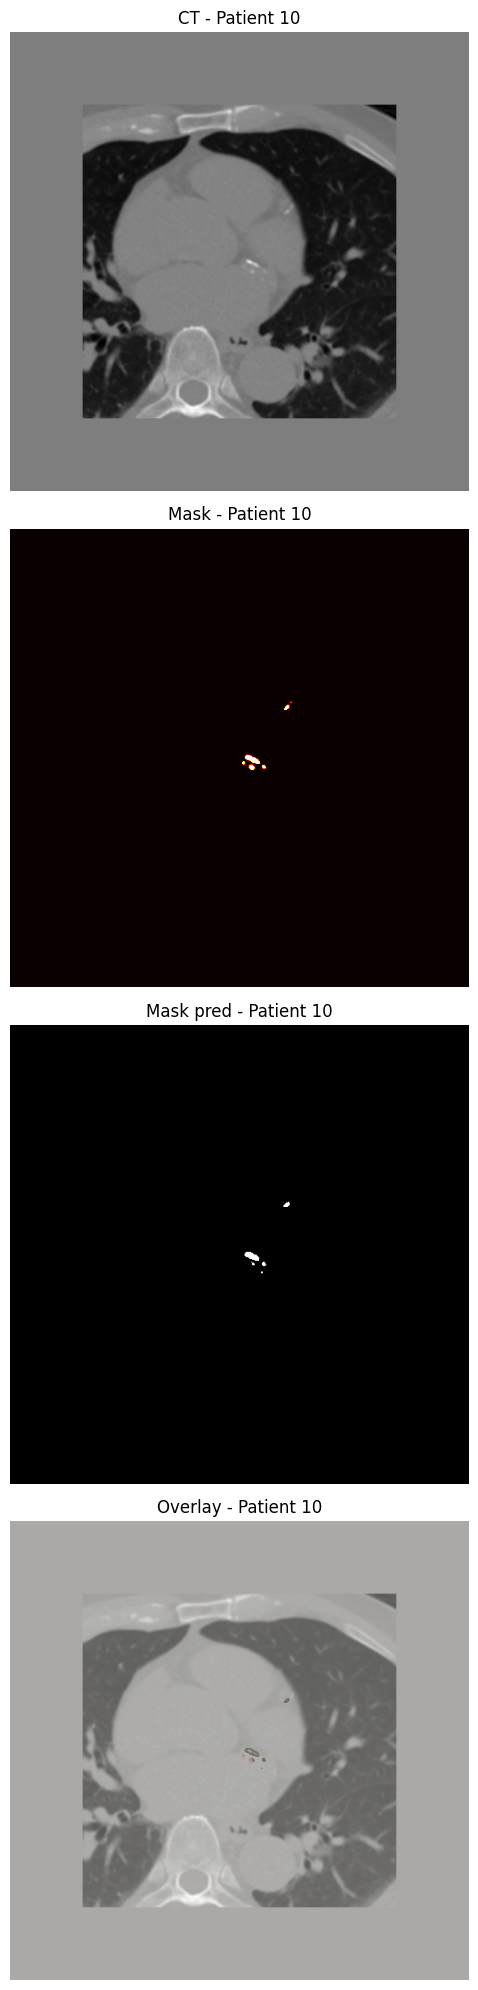

Patient 10 - CT shape: (64, 512, 512, 1), Mask shape: (64, 512, 512, 1)
CT value range: [-1018.00, 2628.00]
Mask value range: [0.00, 1.00]
Predicted Mask value range: [0.00, 1.00]

Predicted Results:
Total predicted Agatston Score: 1072.50
Number of lesions: 22
Total predicted calcium volume: 876.75 mm³
Individual lesion scores: ['52.00', '243.00', '3.00', '0.50', '10.00', '24.75', '7.50', '116.00', '18.75', '10.00', '7.00', '38.00', '163.00', '76.00', '4.50', '7.00', '212.00', '7.00', '29.25', '0.75', '40.50', '2.00']

Advanced analysis:
Density distribution: {'density_1_voxels': 519, 'density_2_voxels': 396, 'density_3_voxels': 144, 'density_4_voxels': 110}
Filtered Agatston Score: 1071.25

Actual Results:
Total Agatston Score: 1109.25
Number of lesions: 25
Total calcium volume: 920.25 mm³
Individual lesion scores: ['47.00', '229.00', '2.50', '1.25', '5.00', '9.00', '21.00', '6.00', '124.00', '47.25', '0.75', '8.50', '7.00', '37.00', '169.00', '71.00', '4.50', '6.00', '194.00', '47.0

In [20]:
visualize_sample(patient_id = 10, slice_idx=22, train_gen=val_gen)

In [21]:
def calculate_agatston_percentage_error(train_gen, model, num_patients, 
                                     pixel_spacing=(0.625, 0.625, 3.0), 
                                     threshold=130, min_lesion_size=1.0):
    """
    Calculate percentage error for Agatston scores
    
    Returns:
        percentage_error: Mean percentage error
        mean_absolute_error: Mean absolute error
        mean_ground_truth: Mean ground truth Agatston score
    """
    all_errors = []
    all_gt_scores = []
    all_pred_scores = []
    
    for patient_id in range(num_patients):
        try:
            # Get CT and ground truth mask
            ct = train_gen[patient_id][0][0]
            gt_mask = train_gen[patient_id][1][0]
            
            # Single-step inference
            ct_input = tf.convert_to_tensor(train_gen[patient_id][0], dtype=tf.float32)
            noisy_mask_input = tf.zeros_like(ct_input)
            timestep_input = tf.constant([0], dtype=tf.int32)
            
            pred = model([ct_input, noisy_mask_input, timestep_input], training=False)
            pred_mask = tf.cast(pred > 0.5, tf.float32).numpy()[0]
            
            # Calculate Agatston scores using YOUR functions
            pred_results = calculate_agatston_score_advanced(
                ct, pred_mask, pixel_spacing, threshold, min_lesion_size
            )
            pred_score = pred_results['filtered_results']['total_agatston_score']
            
            gt_results = calculate_agatston_score_advanced(
                ct, gt_mask, pixel_spacing, threshold, min_lesion_size
            )
            gt_score = gt_results['filtered_results']['total_agatston_score']
            
            # Store values
            error = abs(pred_score - gt_score)
            all_errors.append(error)
            all_gt_scores.append(gt_score)
            all_pred_scores.append(pred_score)
            
            print(f"Patient {patient_id}: Pred={pred_score:.1f}, GT={gt_score:.1f}, Error={error:.1f}")
            
        except Exception as e:
            print(f"Error processing patient {patient_id}: {str(e)}")
            continue
    
    if not all_errors:
        print("No patients processed successfully")
        return None, None, None
    
    # Calculate statistics
    mean_absolute_error = np.mean(all_errors)
    mean_ground_truth_score = np.mean(all_gt_scores)
    mean_pred_score = np.mean(all_pred_scores)
    
    # Calculate percentage error relative to mean ground truth
    if mean_ground_truth_score > 0:
        percentage_error = (mean_absolute_error / mean_ground_truth_score) * 100
    else:
        percentage_error = 0.0
    
    # Print results
    print(f"\n=== Agatston Score Results ===")
    print(f"Mean Absolute Error: {mean_absolute_error:.2f}")
    print(f"Mean Ground Truth Score: {mean_ground_truth_score:.2f}")
    print(f"Mean Predicted Score: {mean_pred_score:.2f}")
    print(f"Percentage Error: {percentage_error:.2f}%")
    print(f"Total patients processed: {len(all_errors)}")
    
    return percentage_error, mean_absolute_error, mean_ground_truth_score

# Simple version - just get the percentage
def get_agatston_percentage_error(train_gen, model, num_patients):
    """
    Simple function to get just the percentage error
    """
    errors = []
    gt_scores = []
    
    for i in range(num_patients):
        try:
            # Get data and inference
            ct = train_gen[i][0][0]
            gt_mask = train_gen[i][1][0]
            
            ct_input = tf.convert_to_tensor(train_gen[i][0], dtype=tf.float32)
            pred = model([ct_input, tf.zeros_like(ct_input), tf.constant([0], dtype=tf.int32)], training=False)
            pred_mask = tf.cast(pred > 0.5, tf.float32).numpy()[0]
            
            # Calculate scores
            pred_score = calculate_agatston_score_advanced(ct, pred_mask)['filtered_results']['total_agatston_score']
            gt_score = calculate_agatston_score_advanced(ct, gt_mask)['filtered_results']['total_agatston_score']
            
            errors.append(abs(pred_score - gt_score))
            gt_scores.append(gt_score)
            
        except Exception as e:
            print(f"Error processing patient {i}: {str(e)}")
            continue
    
    # Calculate percentage error
    mean_absolute_error = np.mean(errors)
    mean_ground_truth_score = np.mean(gt_scores)
    
    percentage_error = (mean_absolute_error / mean_ground_truth_score) * 100 if mean_ground_truth_score > 0 else 0
    
    print(f"Percentage Error: {percentage_error:.2f}%")
    return percentage_error




In [22]:
# Quick percentage calculation
percentage_error = get_agatston_percentage_error(train_gen, model, len(train_gen))




Percentage Error: 11.88%
